### **$Part$ $3$**

---

#### **$Load$ $Libraries$**

---

In [28]:
import os
import re
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler
from peft import get_peft_model, LoraConfig
import matplotlib.pyplot as plt
from tqdm import tqdm 
import random


---

#### $Prepare$ $Dataset$

---

This section imports necessary libraries and structures the dataset for inpainting. It defines paths, collects image-mask-target pairs, and creates a custom InpaintDataset to load, resize, and normalize images and masks, making them ready for the inpainting model.

In [ ]:
# Paths 
data_root = "/dataset"
train_imgs = os.path.join(data_root, "train/source_images")
train_masks = os.path.join(data_root, "predicted_token/train/box")
train_targets = os.path.join(data_root, "train/target_images")
train_instructions = os.path.join(data_root, "train/instructions")


In [3]:
def extract_id(filename):
    m = re.match(r"source_img_(\d+)\.png", filename)
    return m.group(1) if m else None

all_ids = sorted(filter(None, [extract_id(f) for f in os.listdir(train_imgs)]))
image_pairs = []
for _id in all_ids:
    entry = {
        "image": os.path.join(train_imgs, f"source_img_{_id}.png"),
        "mask": os.path.join(train_masks, f"mask_{_id}.png"),
        "target": os.path.join(train_targets, f"target_img_{_id}.png"),
        "instruction": os.path.join(train_instructions, f"instruction_{_id}.txt")
    }
    if all(os.path.exists(p) for p in entry.values()):
        image_pairs.append(entry)
print(f"Loaded {len(image_pairs)} samples.")


Loaded 11250 samples.


In [15]:
class InpaintDataset(Dataset):
    def __init__(self, entries):
        self.entries = entries
        # Transform for the image and target
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]), # Normalize to [-1, 1]
        ])
        # Transform for the mask
        self.mask_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, i):
        e = self.entries[i]
        source_image = self.transform(Image.open(e["image"]).convert("RGB"))
        target_image = self.transform(Image.open(e["target"]).convert("RGB"))
        
        # Load mask and ensure it is binary
        mask = self.mask_transform(Image.open(e["mask"]).convert("L"))
        mask = (mask > 0.4).float() # Binarize the mask to 0s and 1s
        return {"input_image": source_image, "mask": mask, "pixel_values": target_image}


---

#### $Model$ $Initialization$ $-$ $LoRA$ $Setup$

---

Here, the core inpainting model, a pre-trained Stable Diffusion Inpaint Pipeline, is initialized. The DDIMScheduler is set for denoising. Crucially, Low-Rank Adaptation (LoRA) is injected into the U-Net, allowing for efficient fine-tuning by only training a small, specialized subset of the model's parameters.

In [16]:
# Create the dataset
dataset = InpaintDataset(image_pairs)

In [17]:
# Load Pipeline + Scheduler
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
).to("cuda")


pipe.scheduler = DDIMScheduler.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", subfolder="scheduler"
)

pipe.enable_attention_slicing()


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.17it/s]


---

#### $Training$ $Configuration$ $and$ $Custom$ $Trainer$

---

This part configures the training process for the LoRA-enabled U-Net. It sets up the DataLoader for batching, defines TrainingArguments (like batch size, epochs, and learning rate), and implements a custom LoRAInpaintTrainer. This trainer manages the inpainting specific loss calculation, which involves encoding images to latents, adding noise, preparing masked inputs, and predicting the original noise.

In [18]:
# Inject LoRA via PEFT
lora_config = LoraConfig(
    r=4,
    lora_alpha=4,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
)
pipe.unet = get_peft_model(pipe.unet, lora_config)
print("LoRA adapters injected")

LoRA adapters injected


In [19]:
# Freeze all except LoRA
for n, p in pipe.unet.named_parameters():
    p.requires_grad = "lora" in n
trainable = sum(p.numel() for p in pipe.unet.parameters() if p.requires_grad)
print(f"Trainable LoRA params: {trainable:,}")

Trainable LoRA params: 829,952


In [20]:
dataloader = DataLoader(dataset, shuffle=True)
def collate_fn(batch):
    return {
        "input_image": torch.stack([x["input_image"] for x in batch]),
        "mask": torch.stack([x["mask"] for x in batch]),
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
    }


In [21]:
training_args = TrainingArguments(
    output_dir="./lora-inpaint-out",
    per_device_train_batch_size=1,  
    gradient_accumulation_steps=1,  
    num_train_epochs=2,
    learning_rate=1e-4,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=300,
    save_total_limit=2,
    remove_unused_columns=False,
    label_names=["input_image", "mask", "pixel_values"],
    dataloader_pin_memory=True,
)

In [ ]:
class LoRAInpaintTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # The 'model' is pipe.unet. 
        device = model.device

        # Encode the ground truth (target) images into latents
        # This is what we want the model to learn to generate.
        latents = pipe.vae.encode(inputs["pixel_values"].to(device, dtype=model.dtype)).latent_dist.sample()
        latents = latents * pipe.vae.config.scaling_factor 

        # Create random noise and a random timestep
        noise = torch.randn_like(latents)
        batch_size = latents.shape[0]
        timesteps = torch.randint(
            0, pipe.scheduler.config.num_train_timesteps, (batch_size,), device=device
        ).long()

        # Add noise to the latents to create the "noisy_latents"
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        # Get the text embeddings for conditioning 
        prompts = [""] * batch_size # Using an empty prompt is standard for unconditional inpainting
        text_inputs = pipe.tokenizer(prompts, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        encoder_hidden_states = pipe.text_encoder(text_inputs.input_ids.to(device))[0]

        # Prepare the mask and the masked image latents
        # The source image is not directly used, we create the masked latents from the target
        mask = F.interpolate(inputs["mask"].to(device), size=(64, 64))
        masked_image_latents = latents * (1 - mask) # Create masked latents

        # Concatenate to create the 9-channel input for the U-Net
        # Correct order: [noisy_latents (4ch), mask (1ch), masked_image_latents (4ch)]
        model_input = torch.cat([noisy_latents, mask, masked_image_latents], dim=1)

        # Predict the noise
        noise_pred = model(model_input, timesteps, encoder_hidden_states).sample

        # Calculate the loss against the original noise
        # This is the crucial part: the loss is on the predicted noise vs original noise
        loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        return (loss, {"noise_pred": noise_pred}) if return_outputs else loss


In [23]:
trainer = LoRAInpaintTrainer(
    model=pipe.unet,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn	
)

In [ ]:
trainer.train()
print("Training complete")


Training complete


---

#### $Inference$ $and$ $Visualization$

---

This section demonstrates how to use the fine-tuned inpainting model. It loads the best LoRA checkpoint, runs inference on a selected sample using the source image and a predicted mask, and then visualizes the original source, the mask, the ground truth target, and the model's final inpainted prediction.

In [24]:

# Find the latest LoRA checkpoint
output_dir = "./lora-inpaint-out"
all_checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
# Sort by step number (the number after the a '-') to find the latest
latest_checkpoint = sorted(all_checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
lora_model_path = os.path.join(output_dir, latest_checkpoint)

print(f"Loading fine-tuned LoRA weights from: {lora_model_path}")

Loading fine-tuned LoRA weights from: ./lora-inpaint-out/checkpoint-22500


In [25]:

# Load the fine-tuned pipeline
base_model_id = "stabilityai/stable-diffusion-2-inpainting"

# Load the base pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)

# Load the LoRA weights from your training
pipe.load_lora_weights(lora_model_path)

# Move the pipeline to the GPU and set it to evaluation mode
pipe.to("cuda")



Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.90it/s]
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.34.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.02it/s]


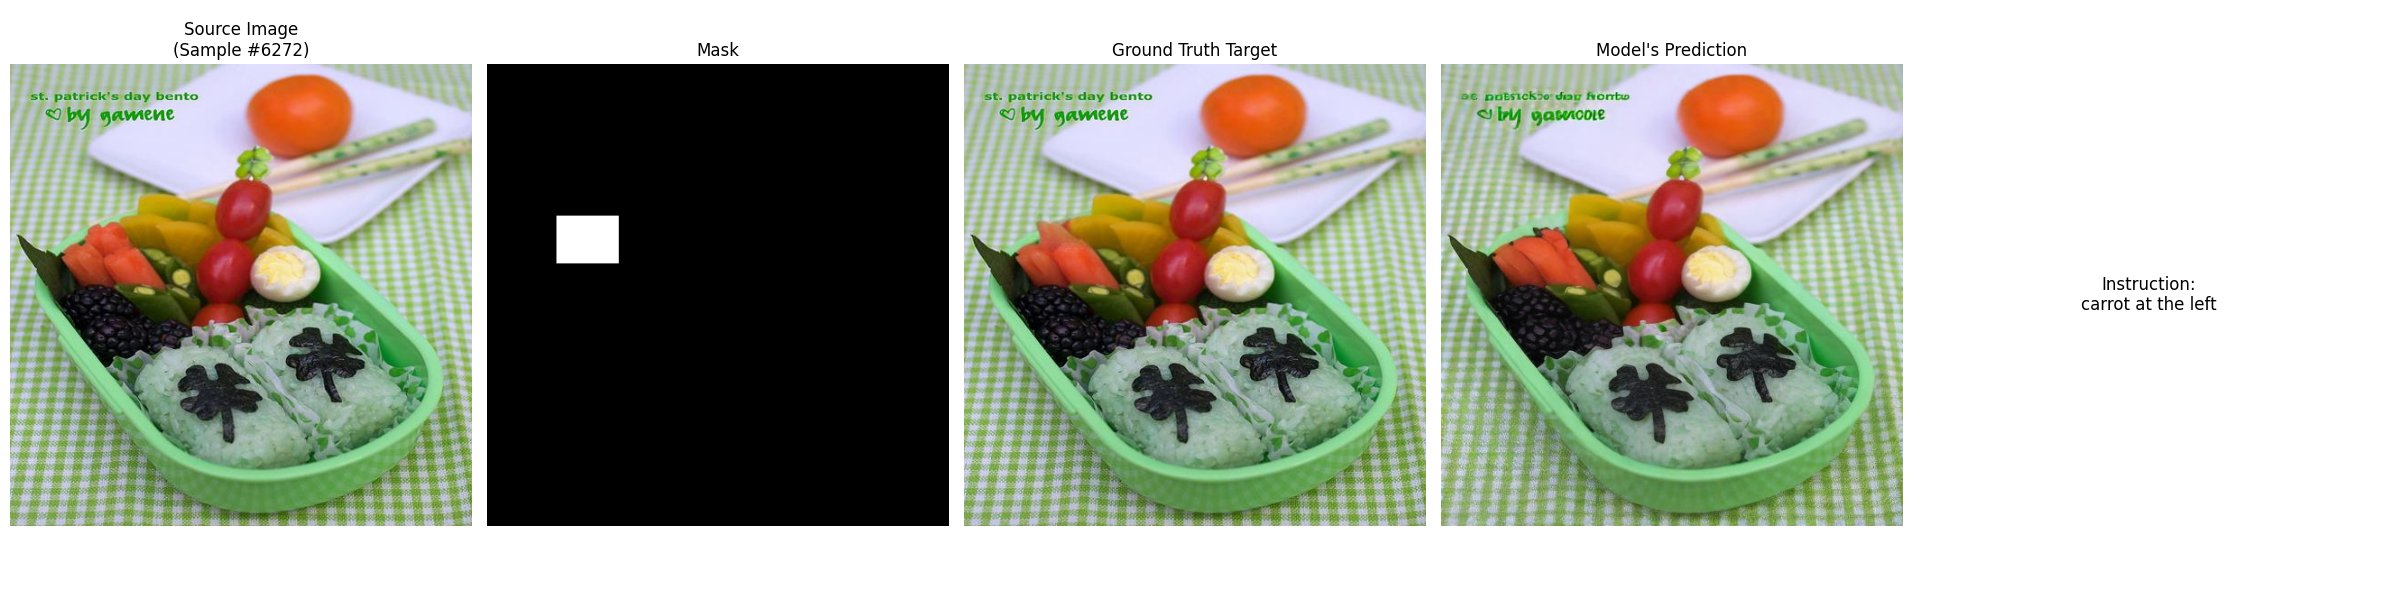

100%|██████████| 50/50 [00:02<00:00, 23.28it/s]


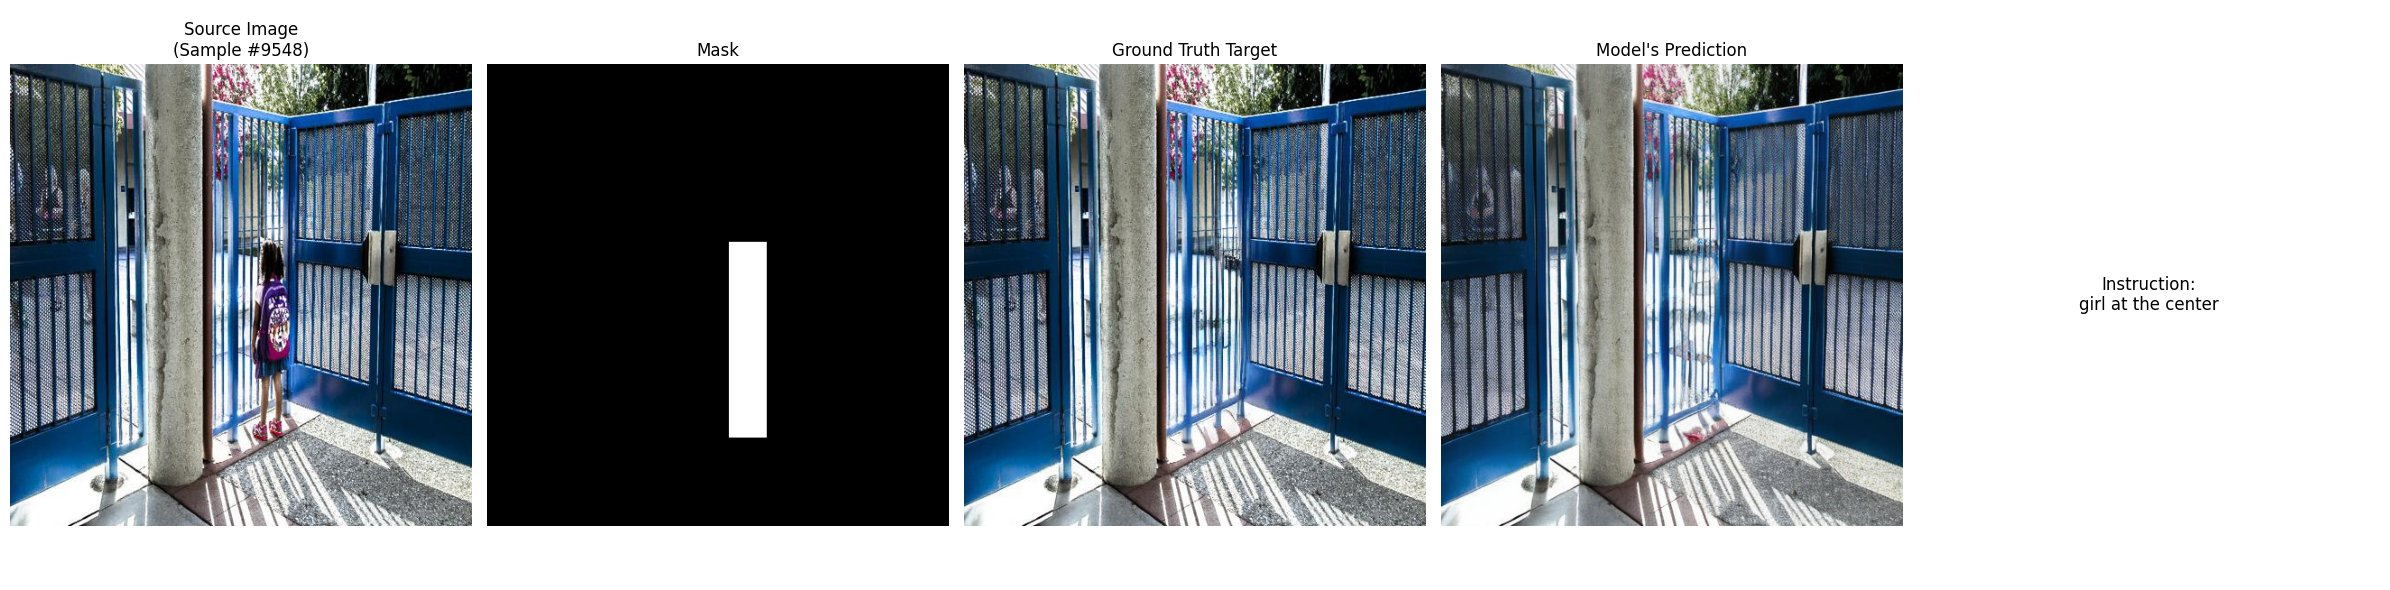

100%|██████████| 50/50 [00:02<00:00, 23.24it/s]


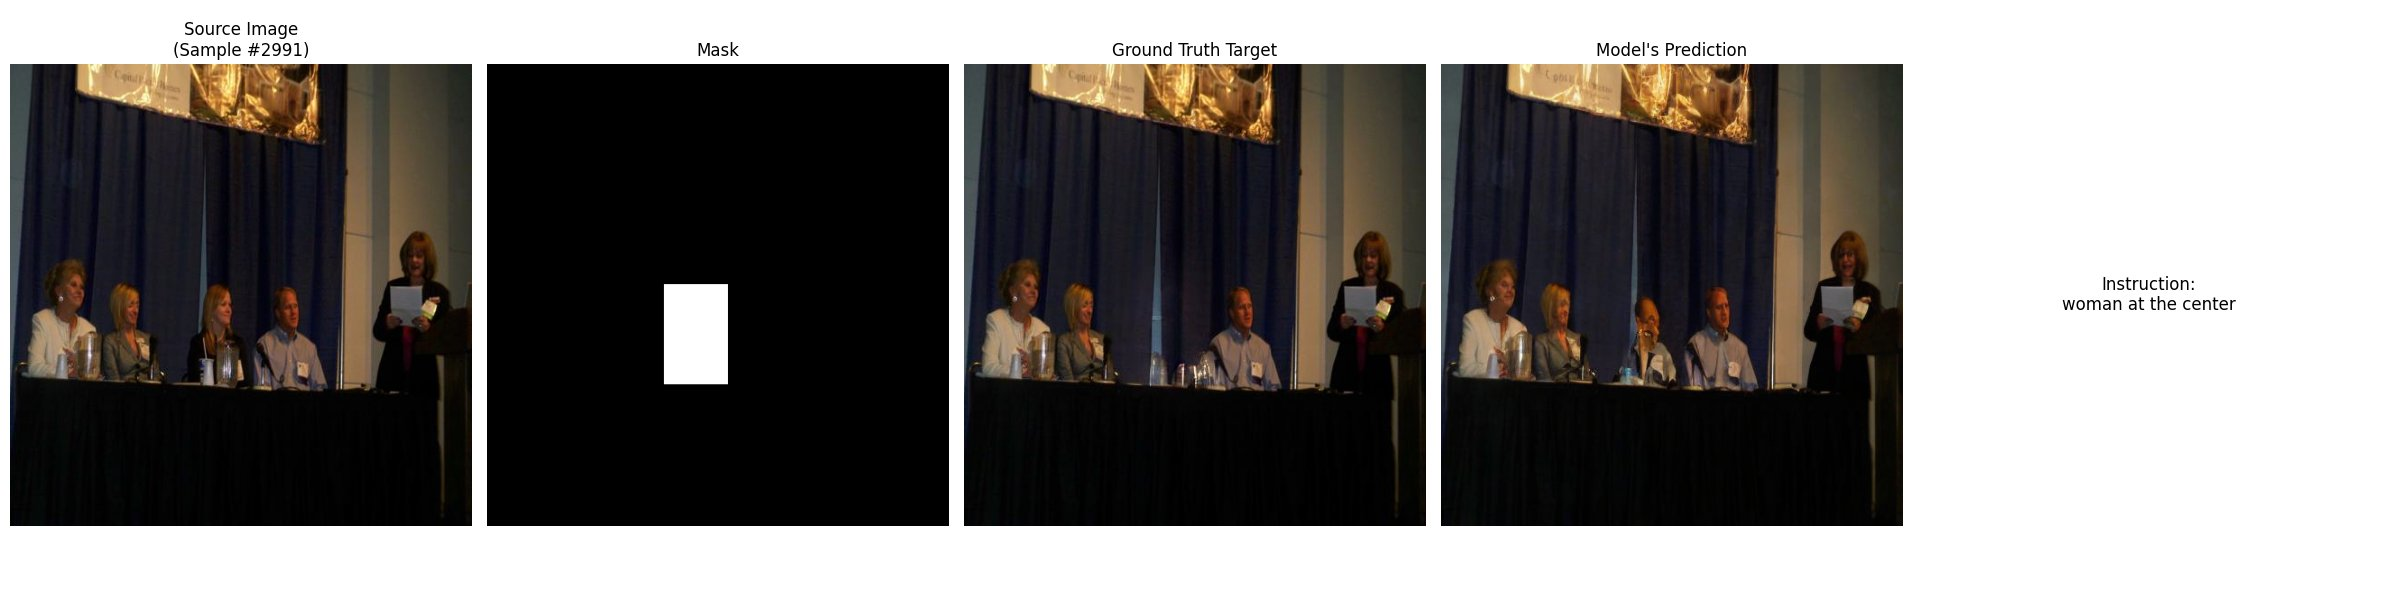

100%|██████████| 50/50 [00:02<00:00, 23.20it/s]


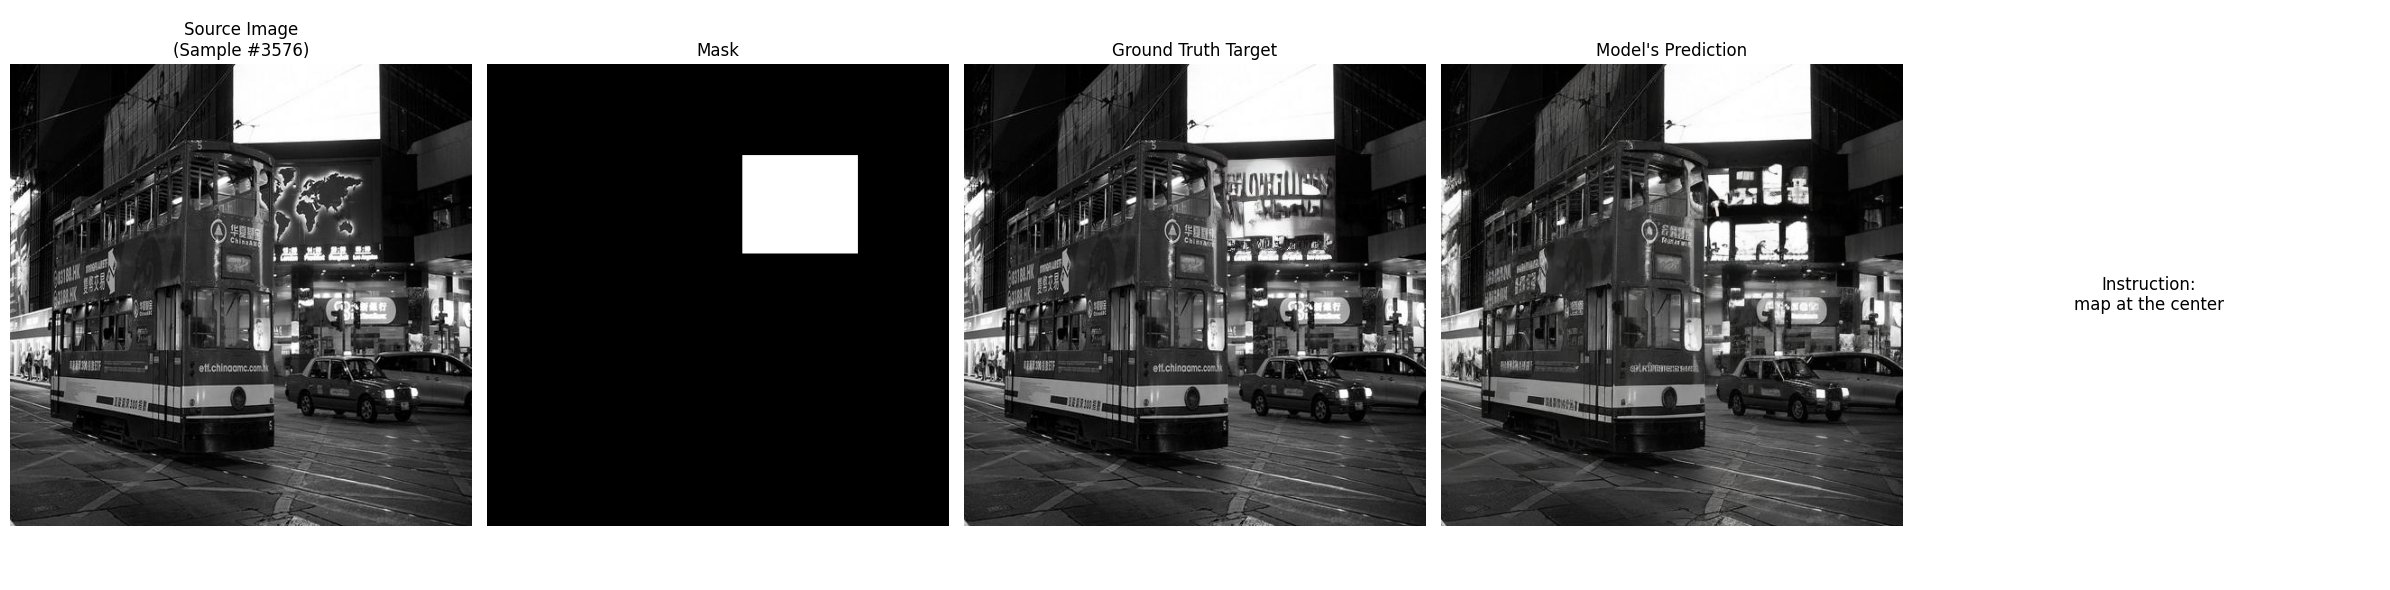

100%|██████████| 50/50 [00:02<00:00, 23.18it/s]


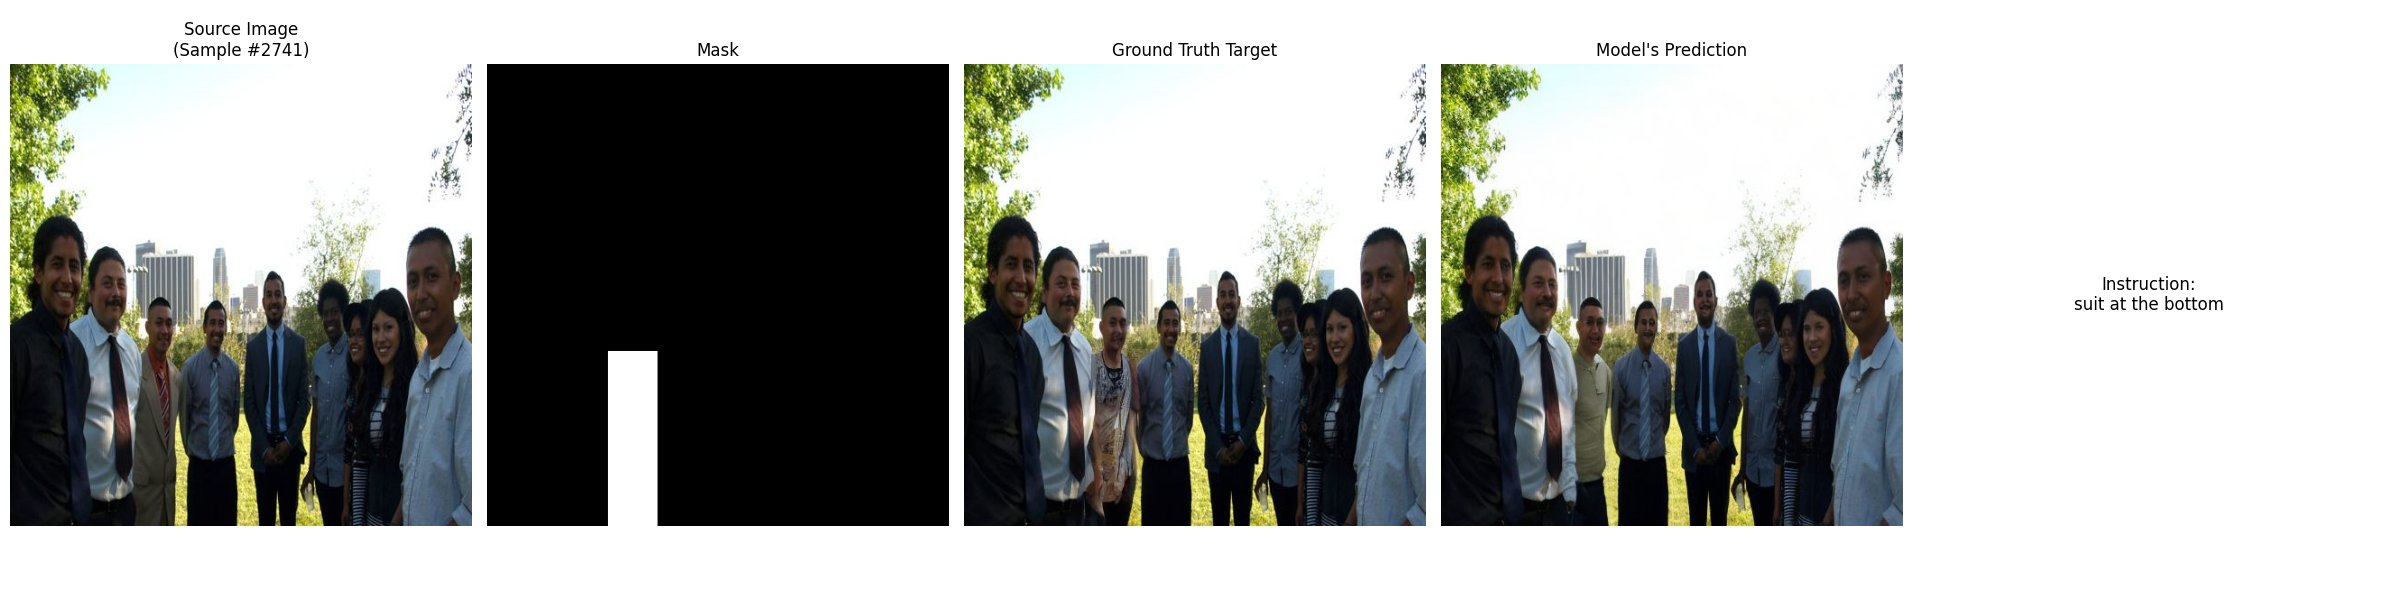

100%|██████████| 50/50 [00:02<00:00, 23.14it/s]


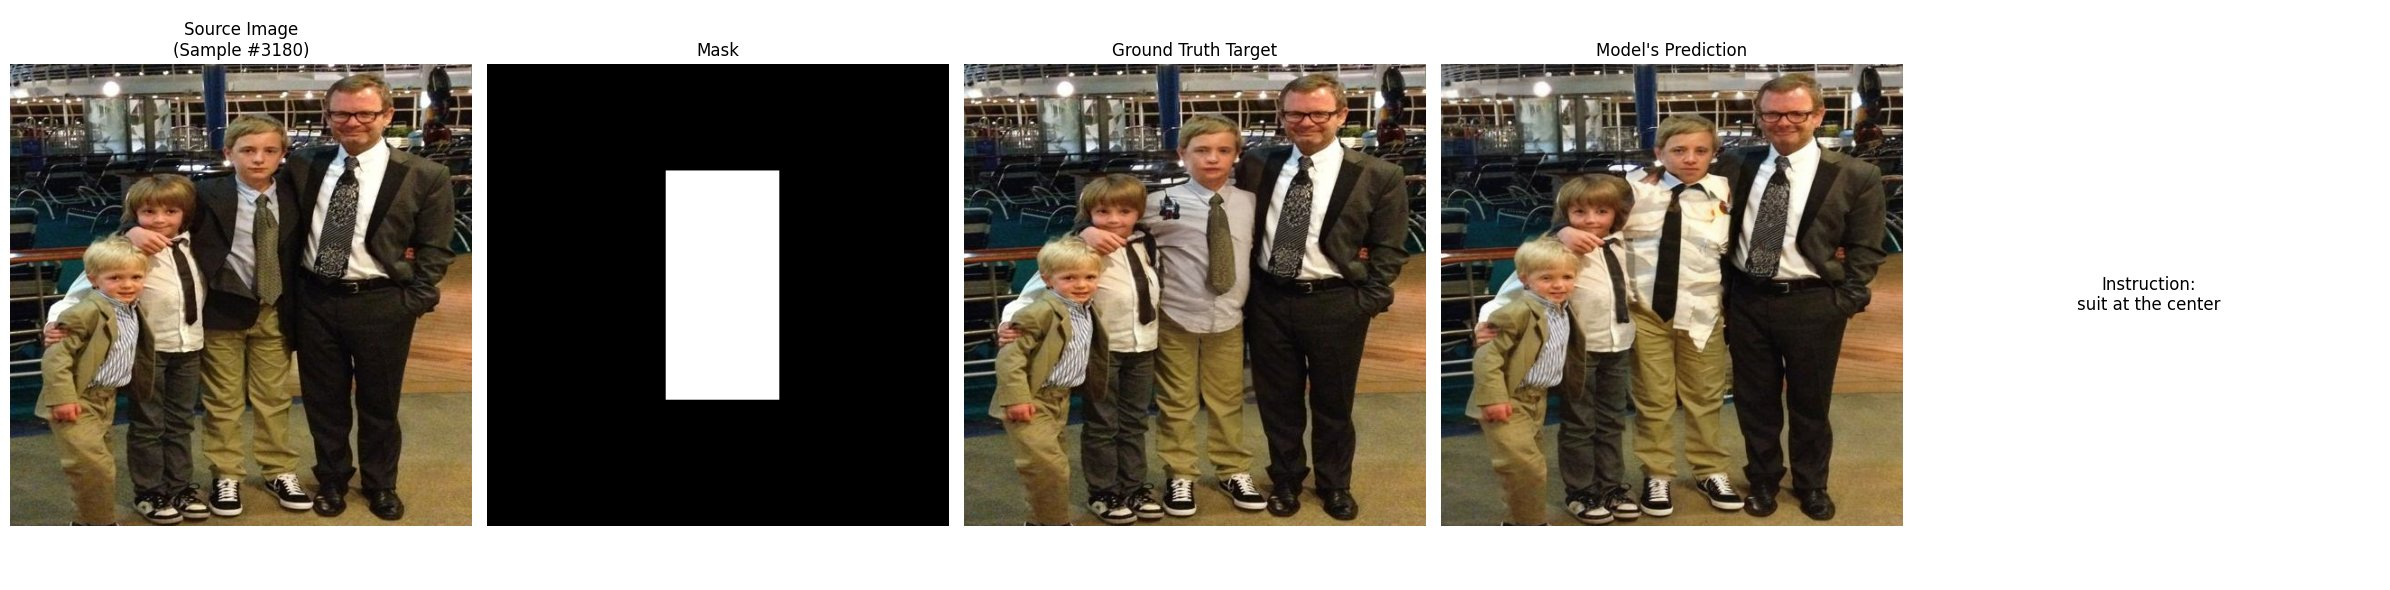

100%|██████████| 50/50 [00:02<00:00, 23.09it/s]


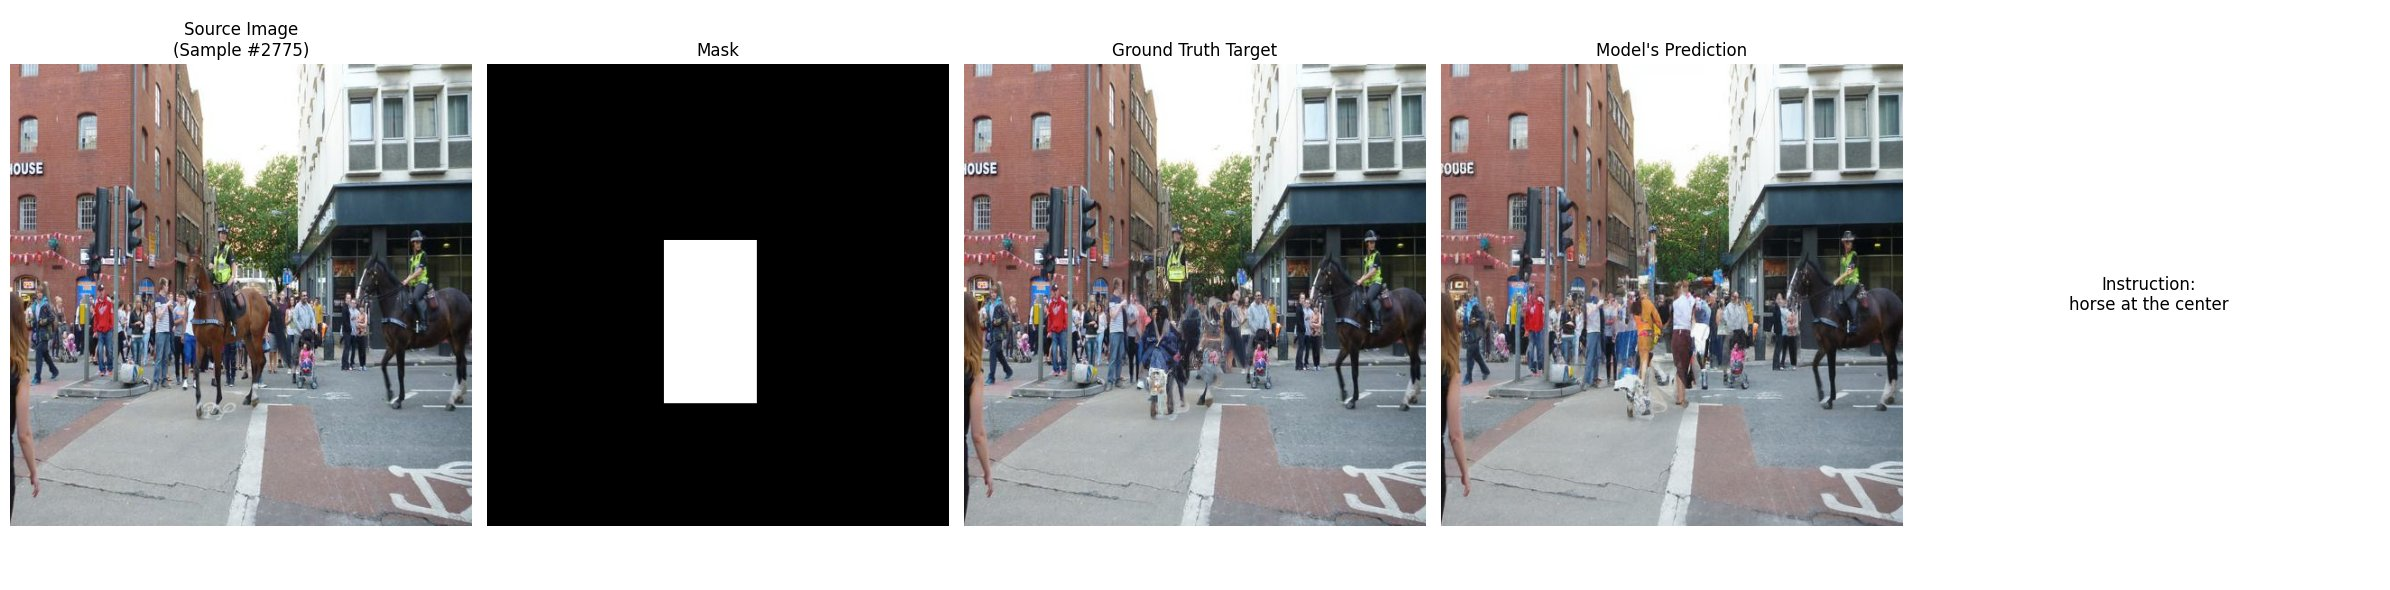

100%|██████████| 50/50 [00:02<00:00, 23.06it/s]


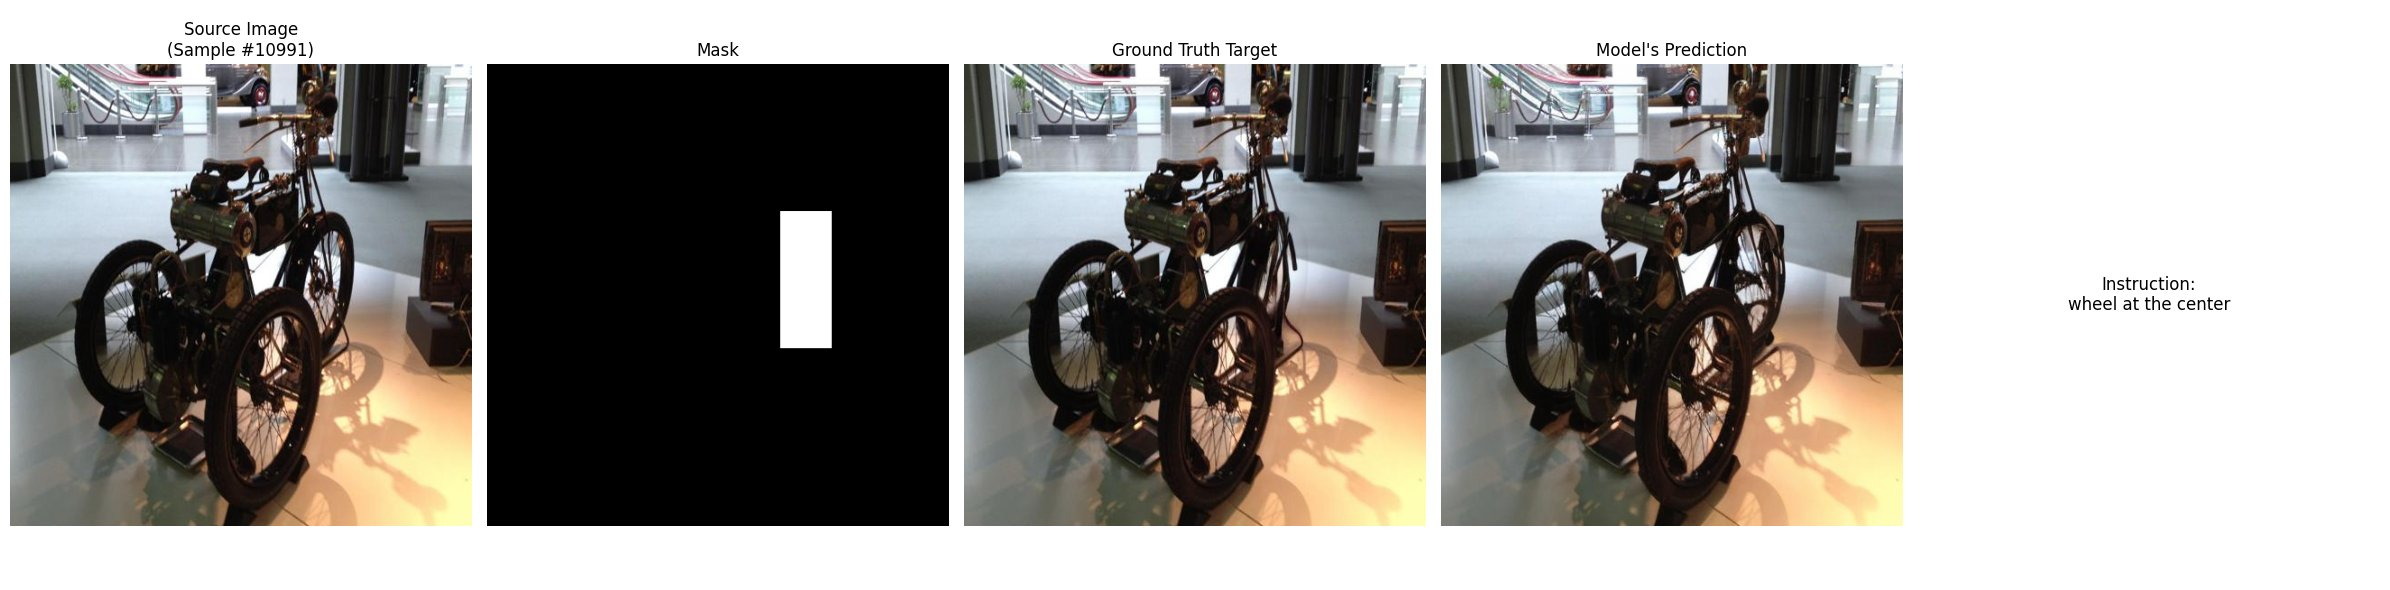

100%|██████████| 50/50 [00:02<00:00, 23.05it/s]


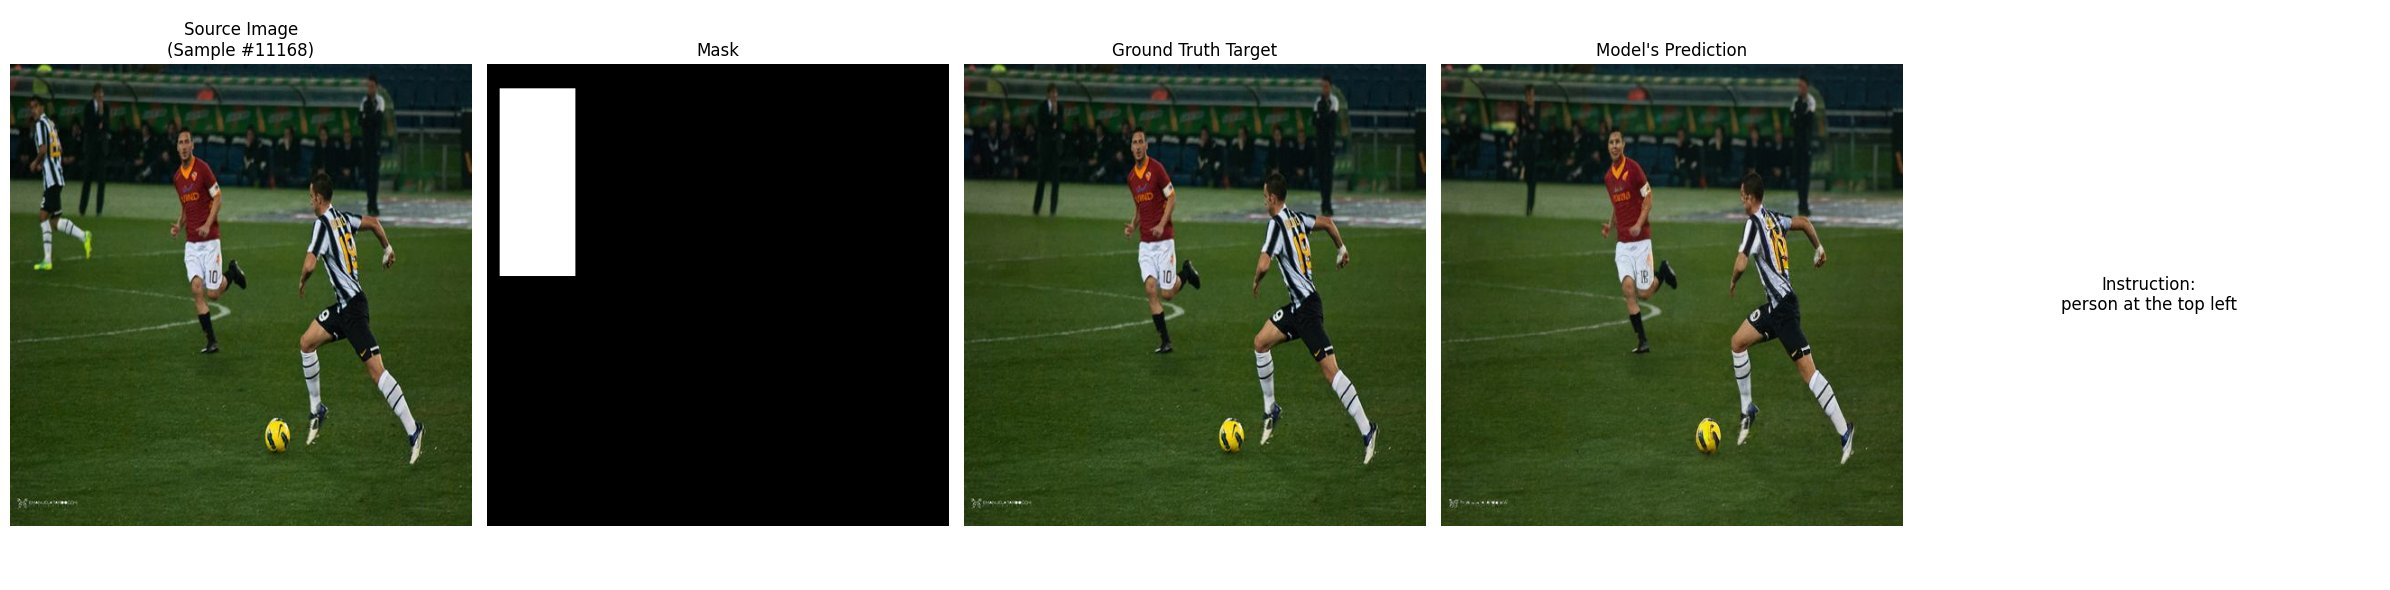

100%|██████████| 50/50 [00:02<00:00, 23.01it/s]


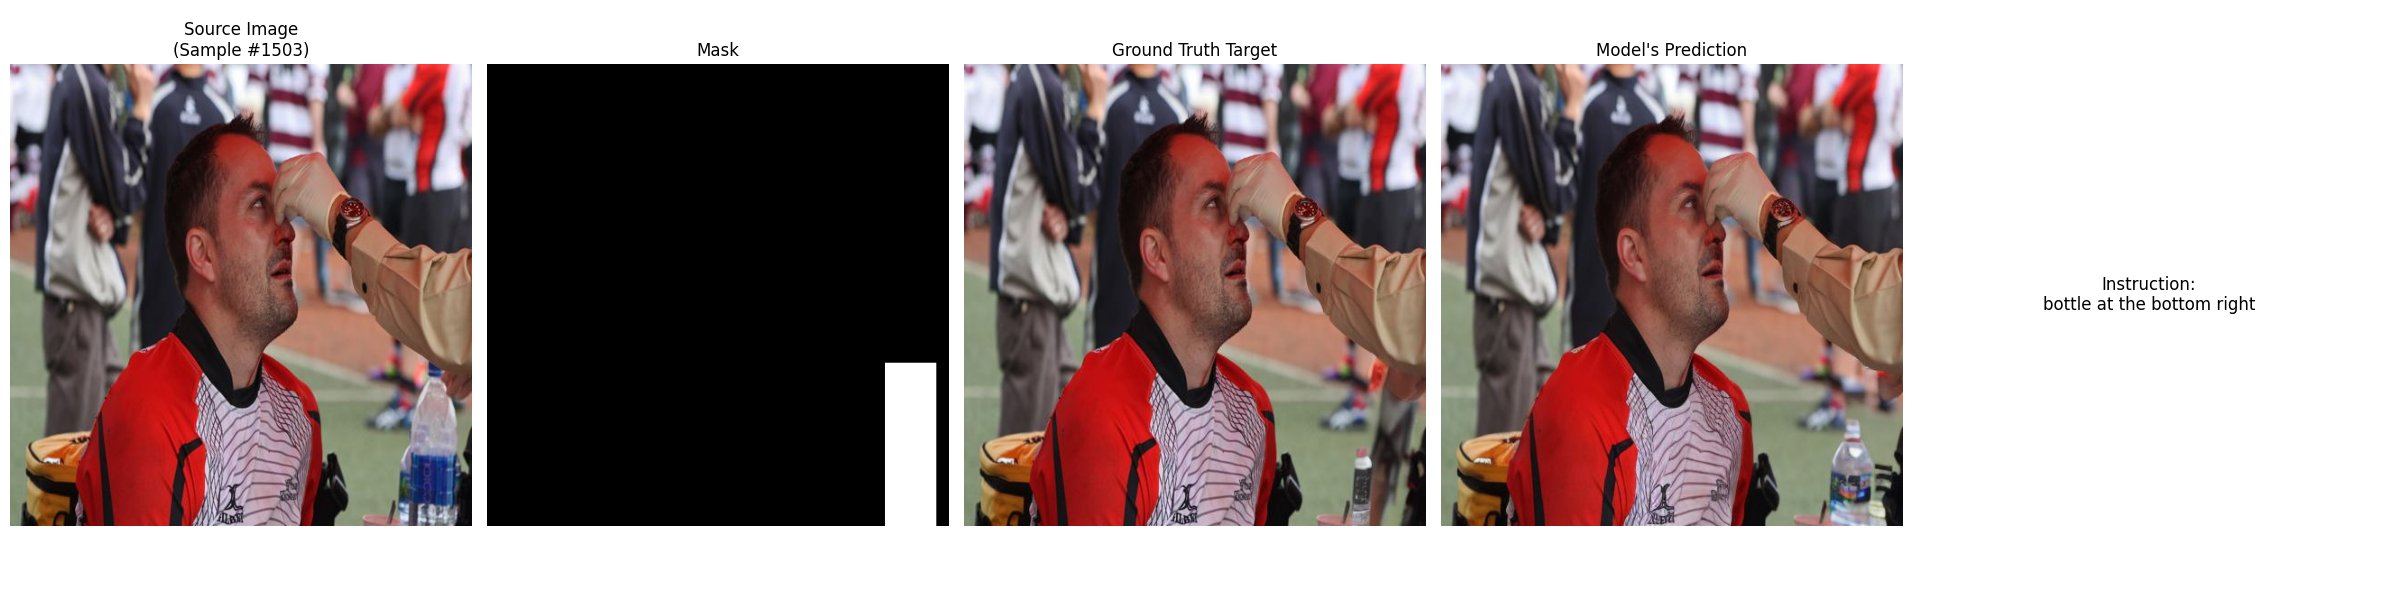

100%|██████████| 50/50 [00:02<00:00, 22.99it/s]


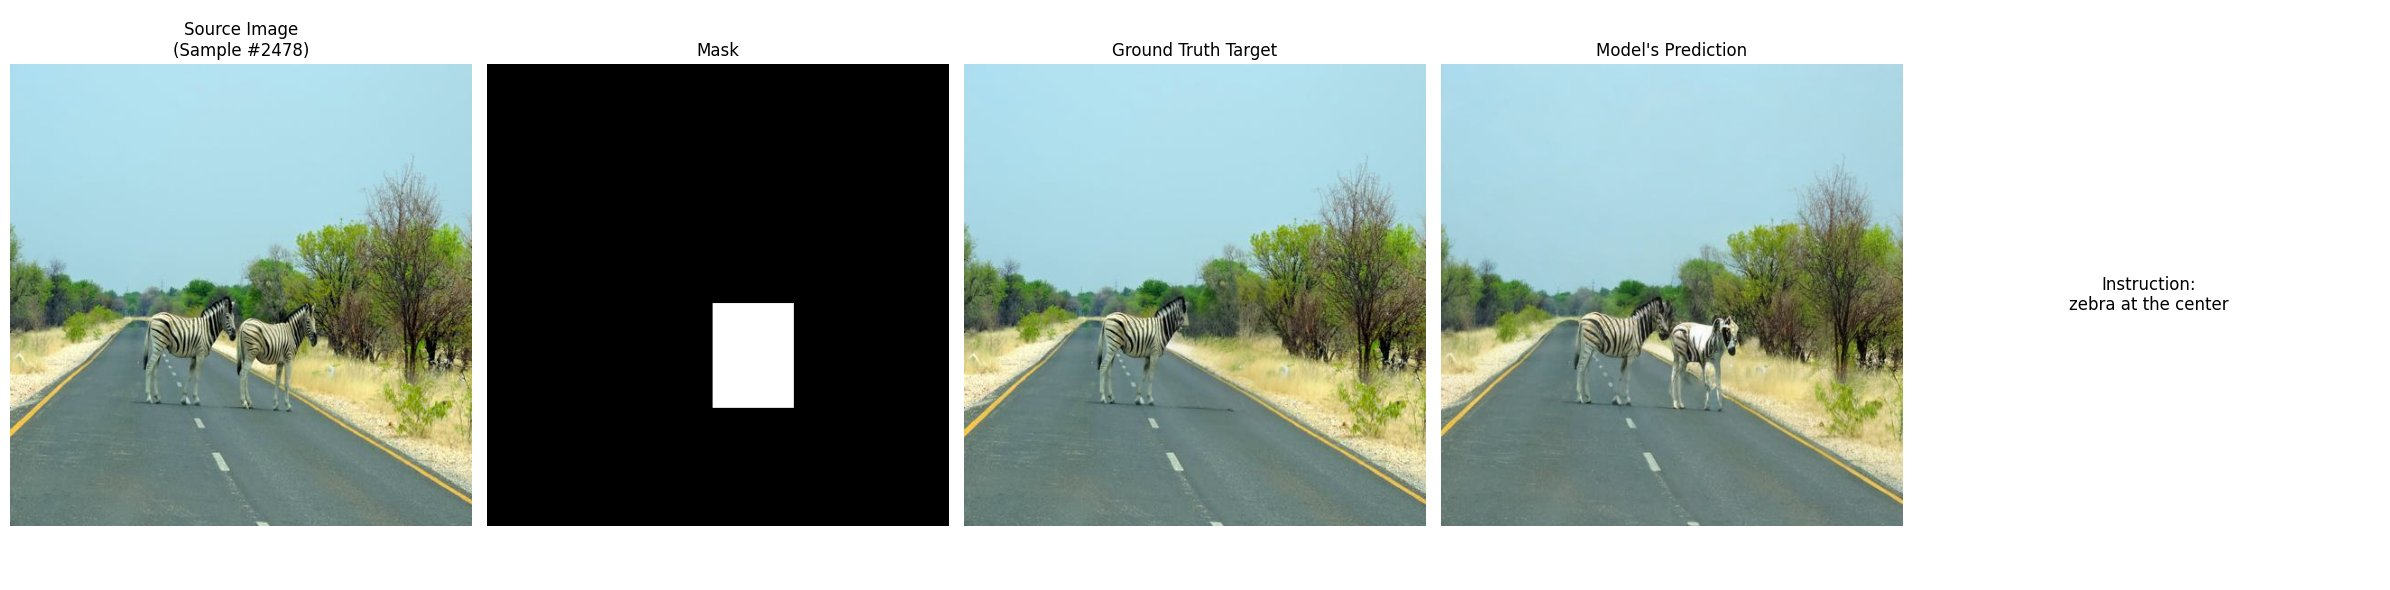

100%|██████████| 50/50 [00:02<00:00, 22.97it/s]


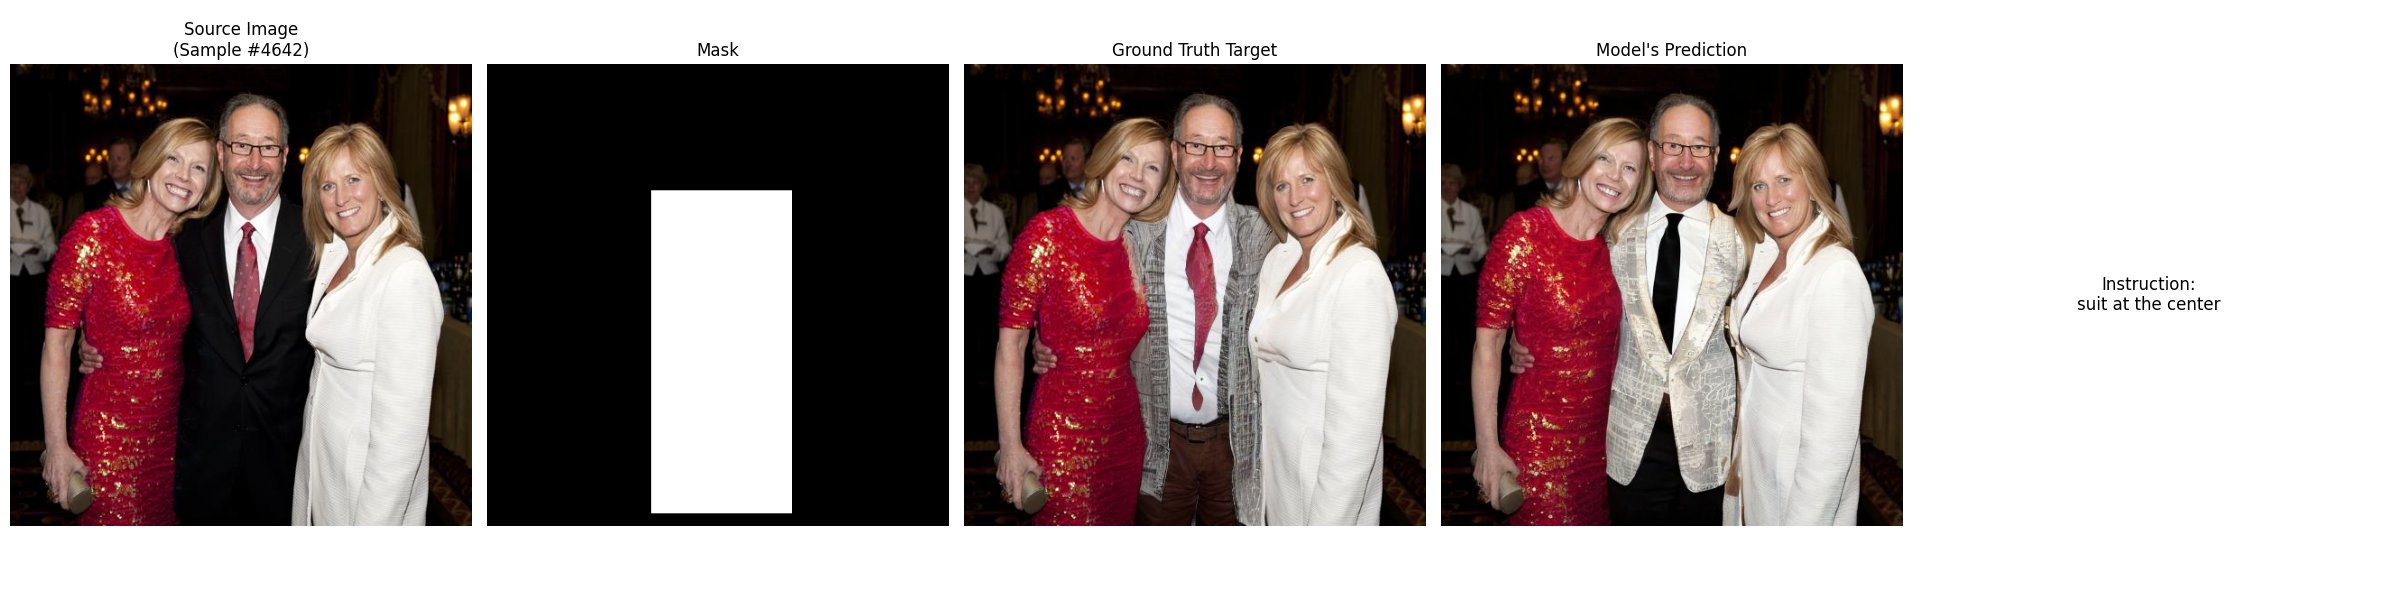

100%|██████████| 50/50 [00:02<00:00, 22.91it/s]


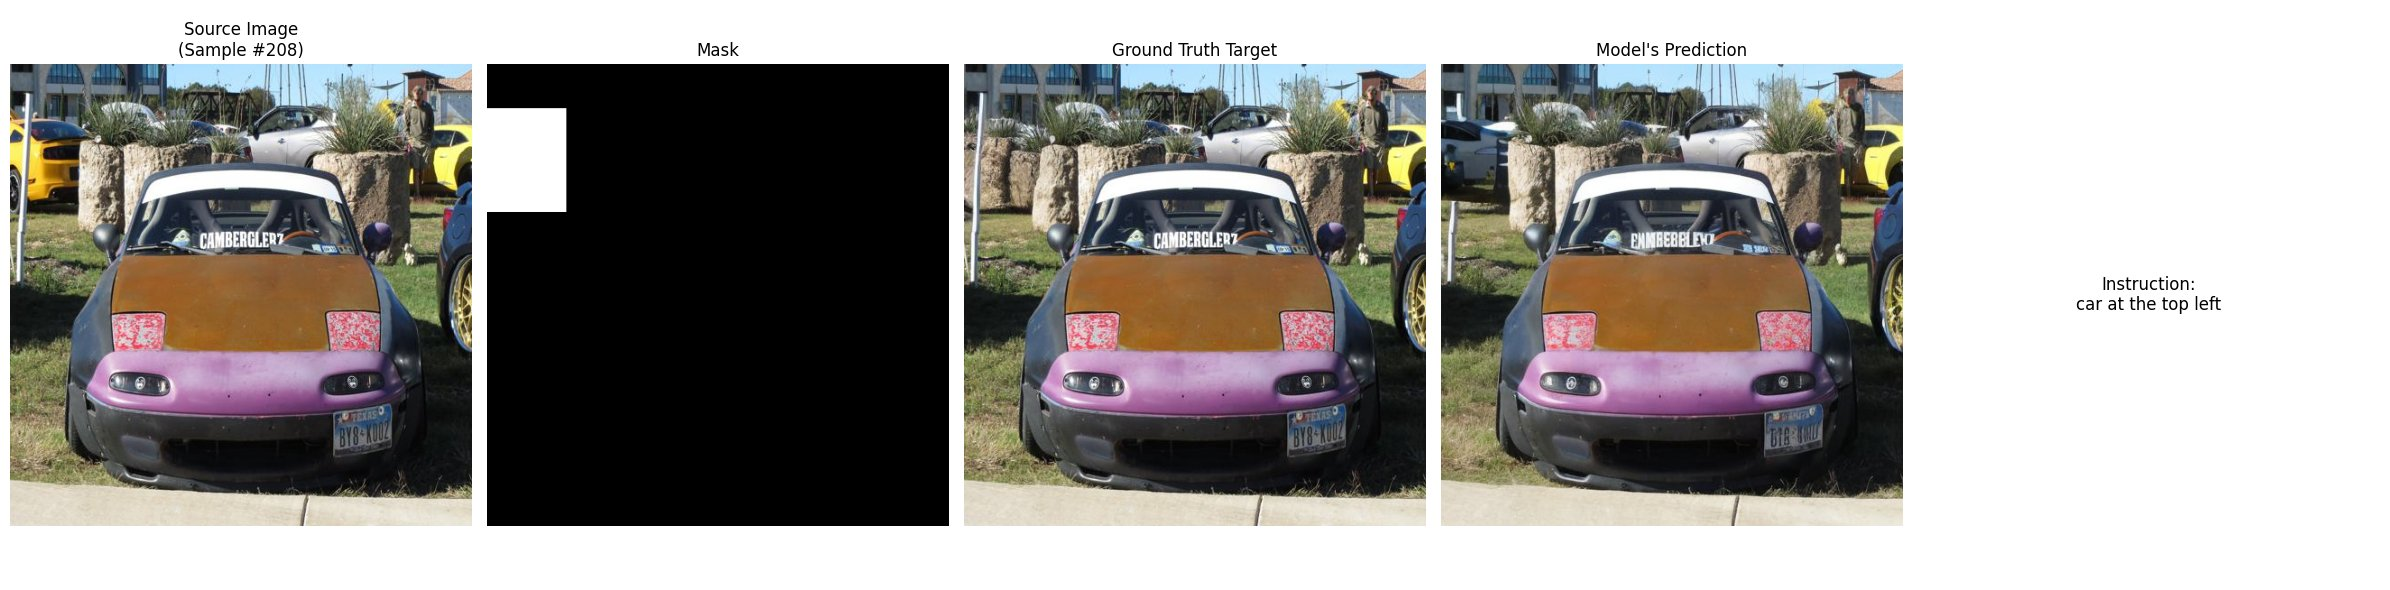

100%|██████████| 50/50 [00:02<00:00, 22.88it/s]


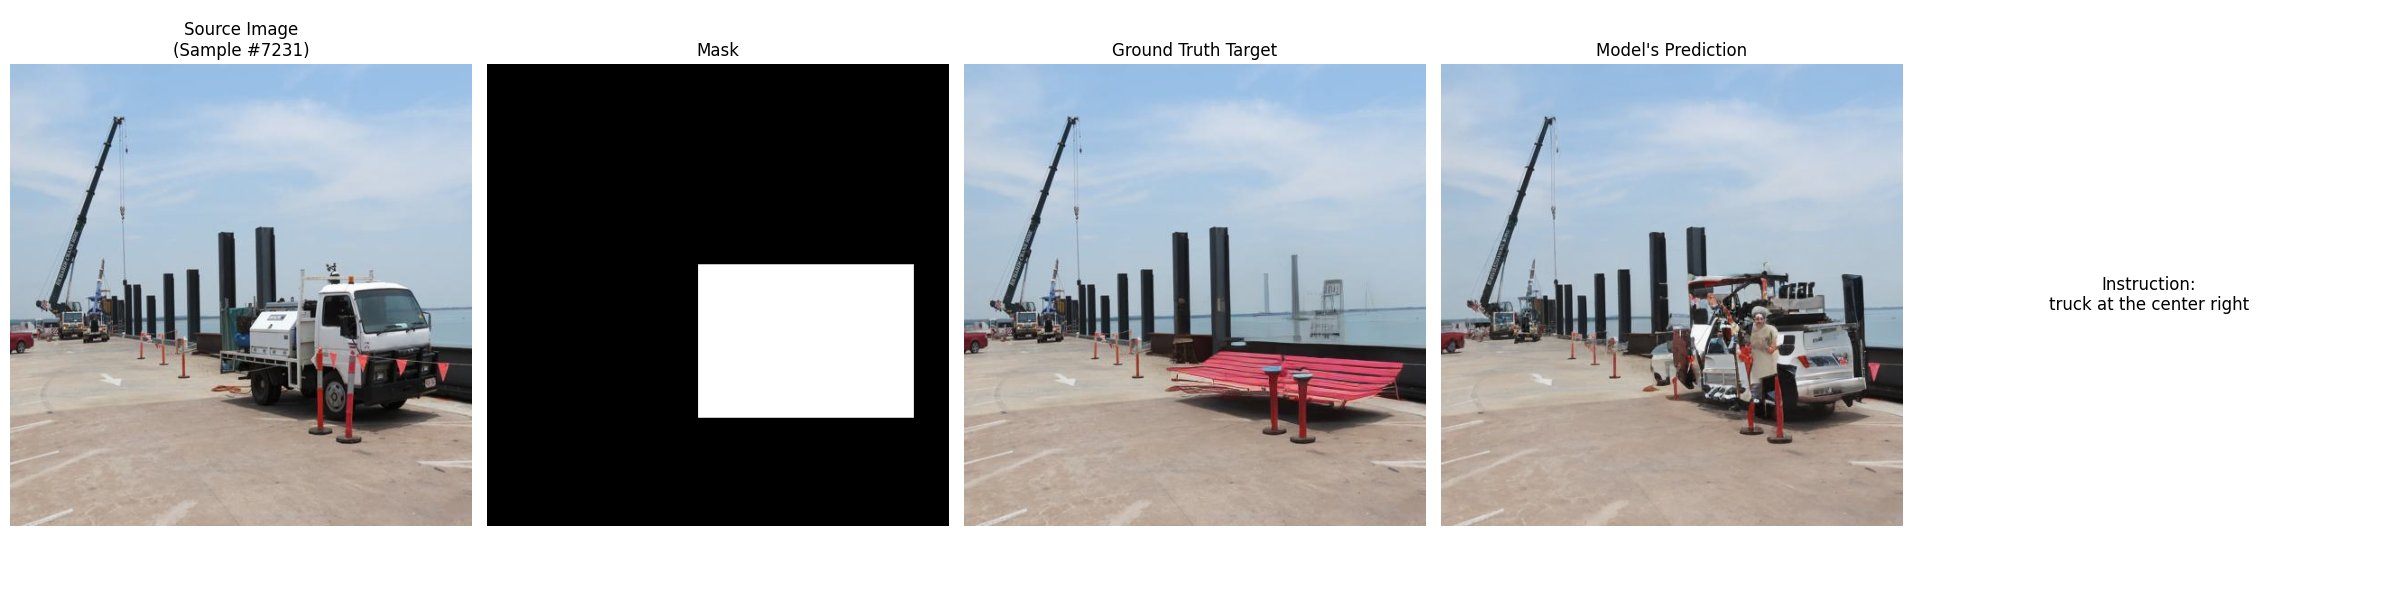

100%|██████████| 50/50 [00:02<00:00, 22.86it/s]


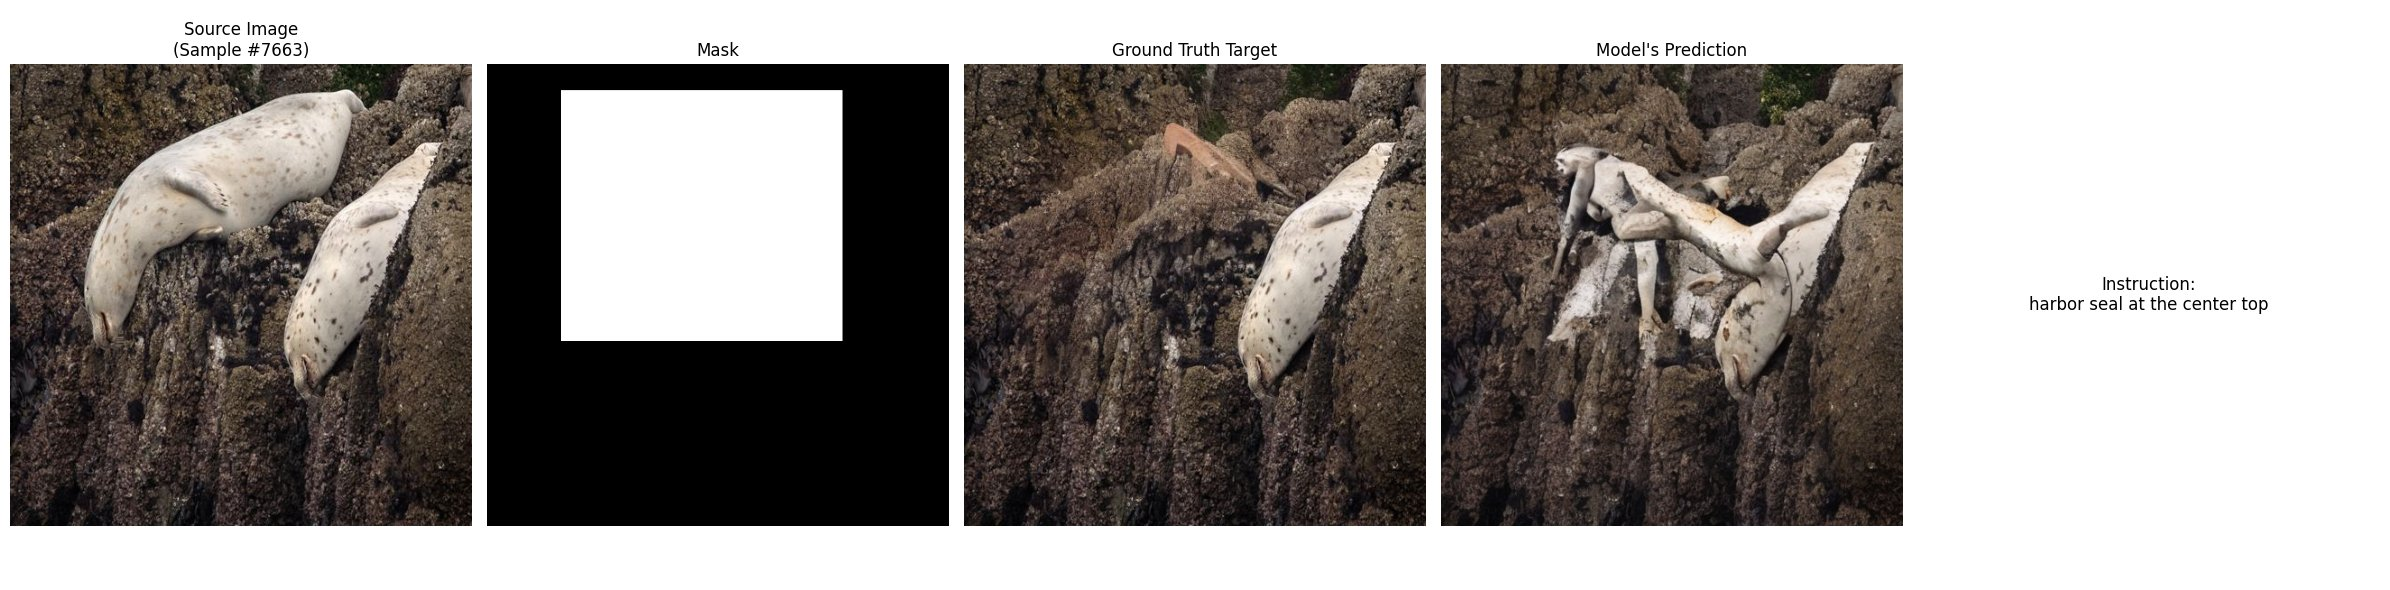

100%|██████████| 50/50 [00:02<00:00, 22.84it/s]


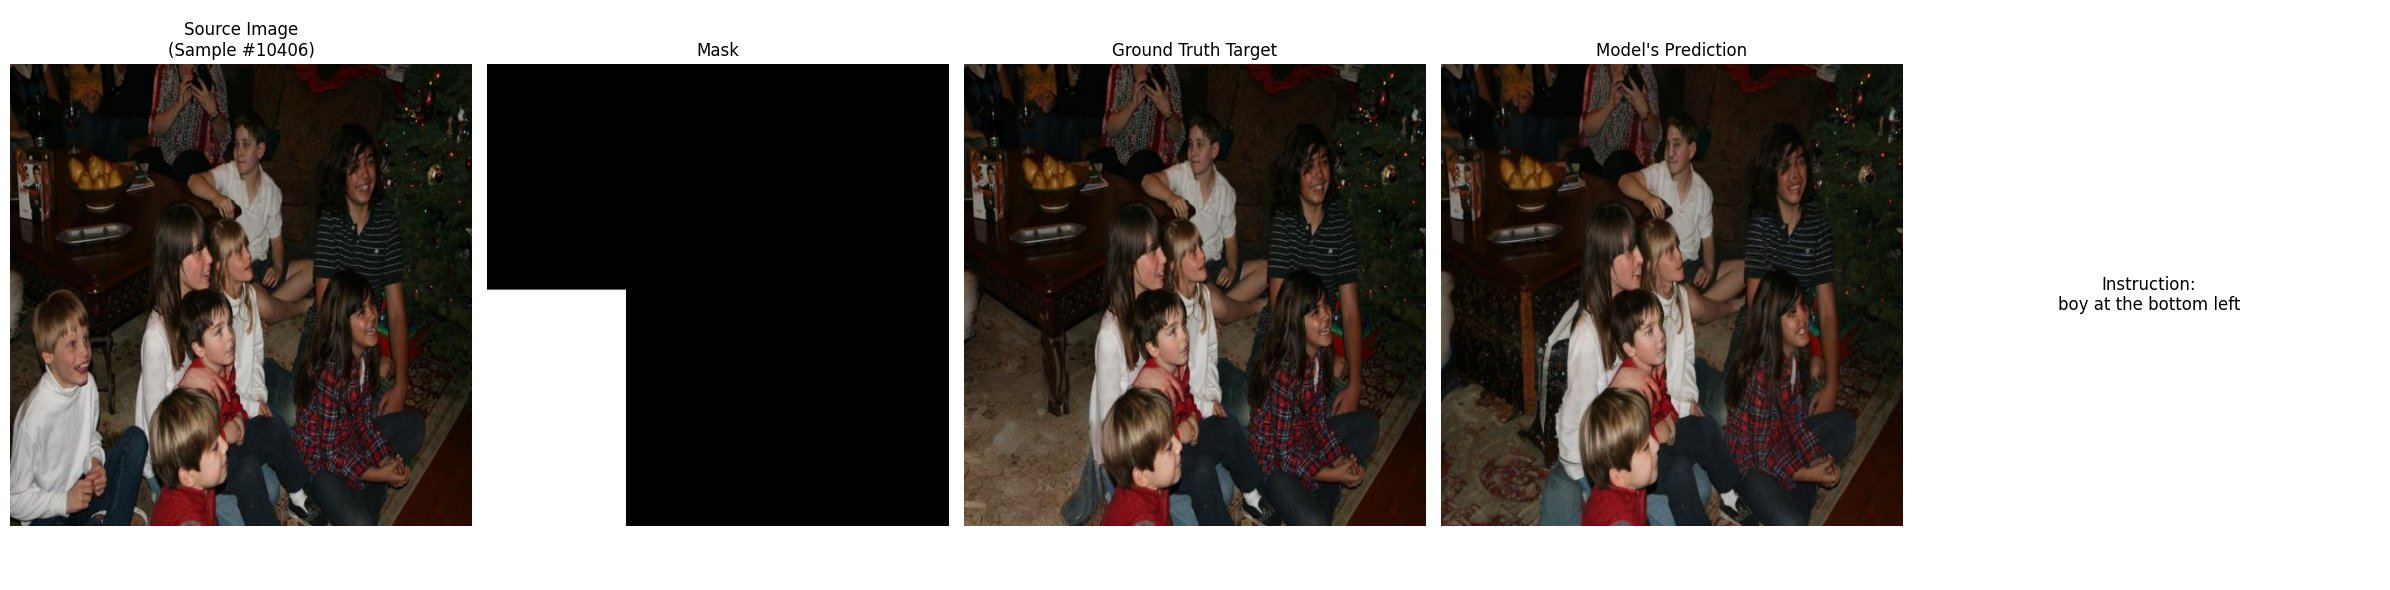

100%|██████████| 50/50 [00:02<00:00, 22.83it/s]


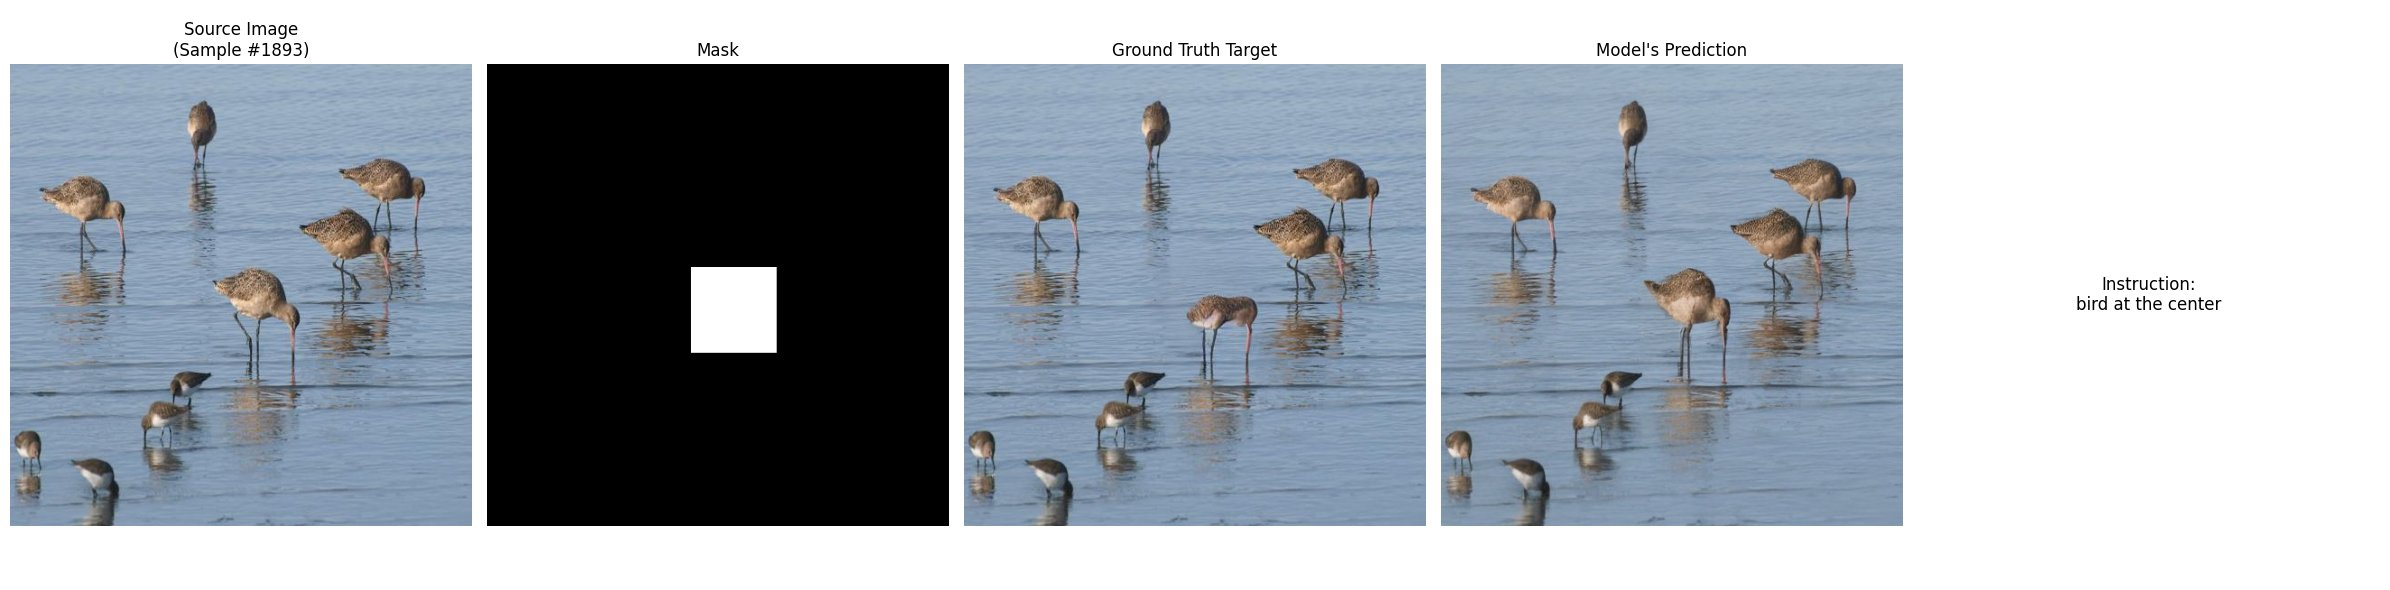

100%|██████████| 50/50 [00:02<00:00, 22.79it/s]


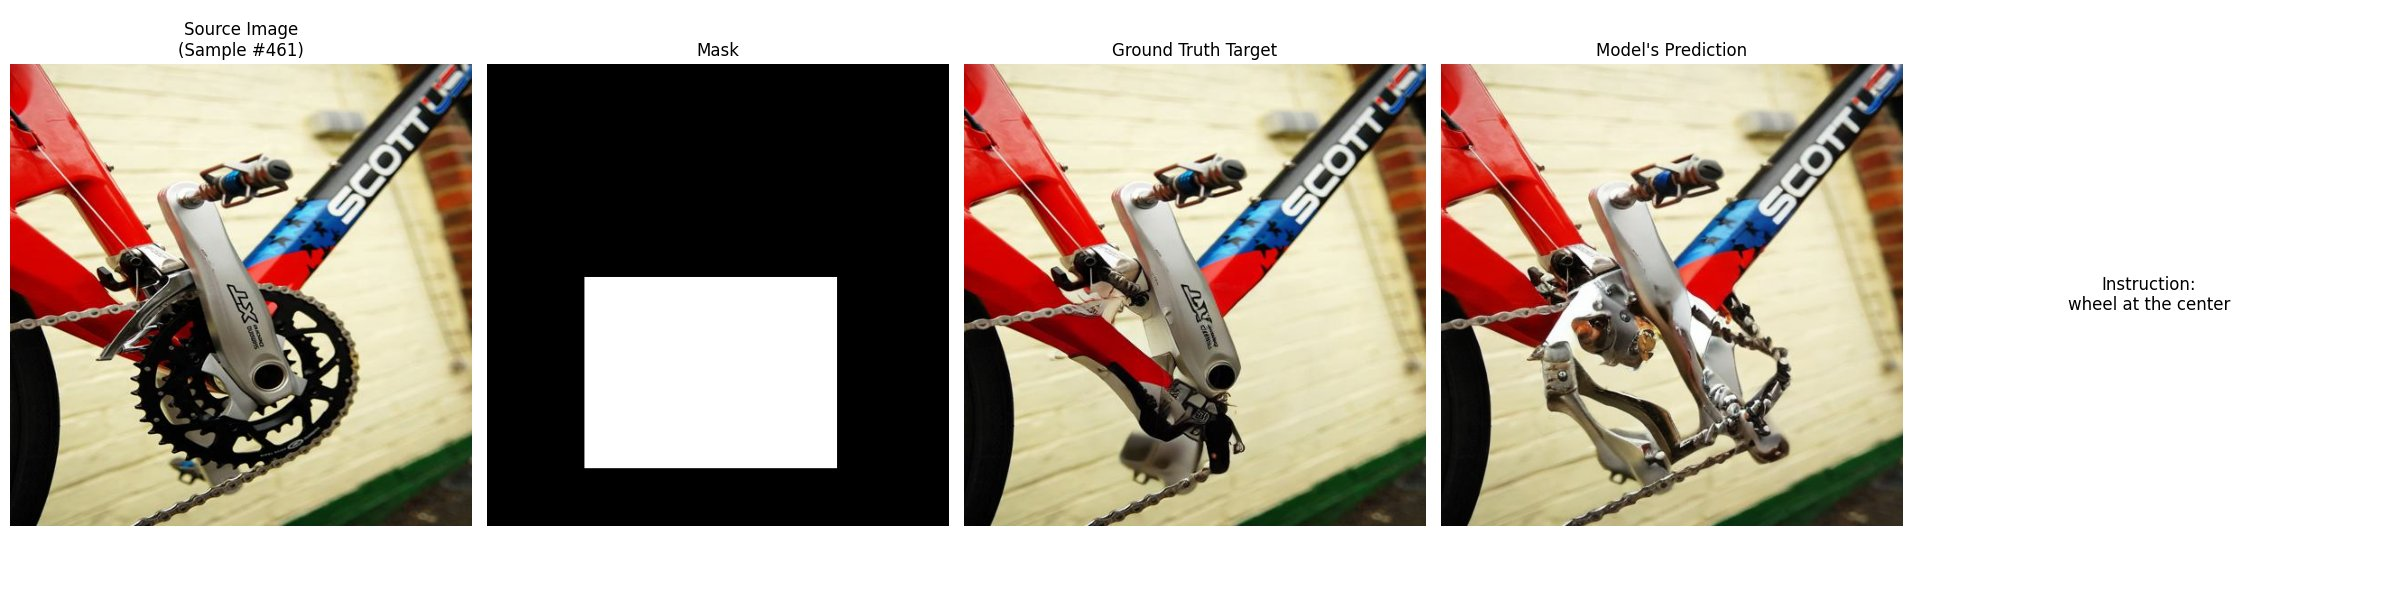

100%|██████████| 50/50 [00:02<00:00, 22.78it/s]


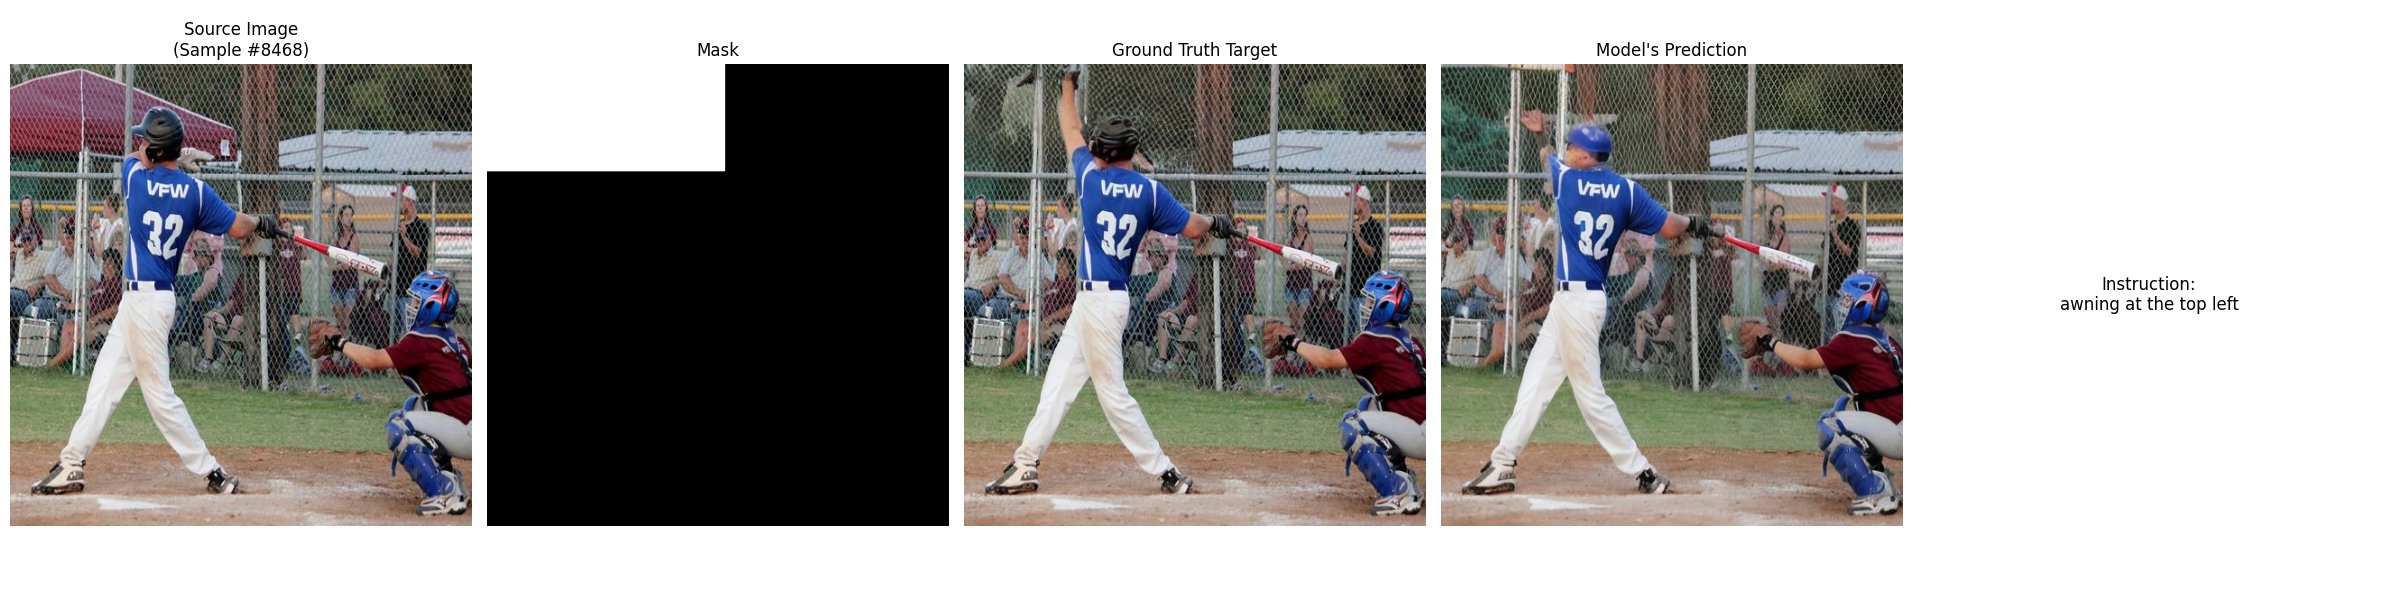

100%|██████████| 50/50 [00:02<00:00, 22.74it/s]


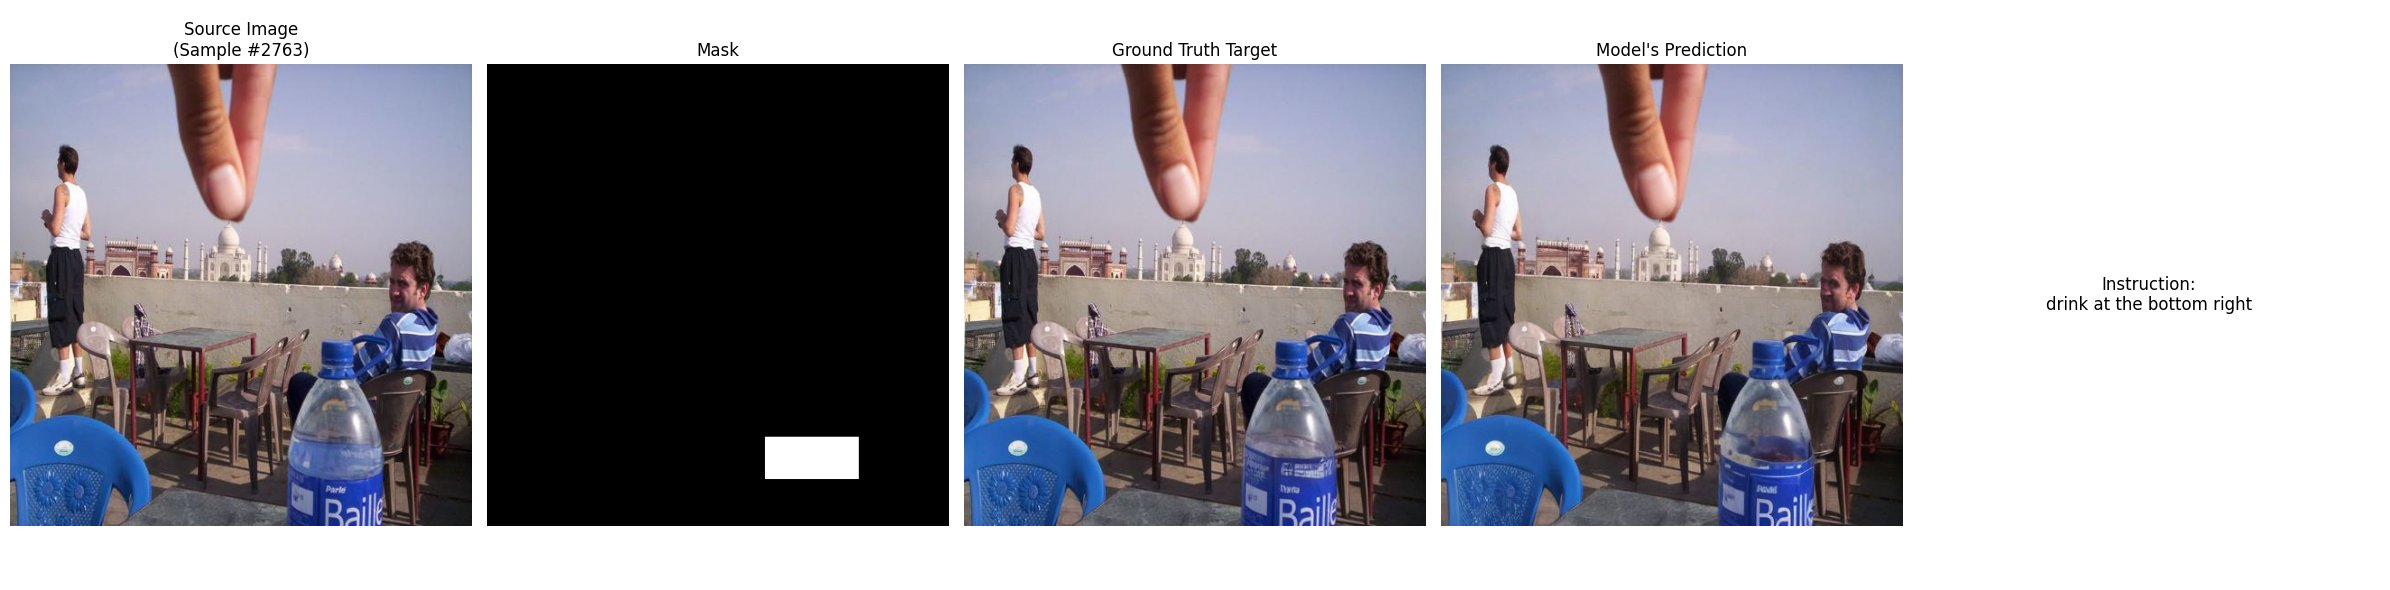

In [ ]:
# Set a seed for reproducibility
random.seed(24)

# Choose 20 random sample indices
random_indices = random.sample(range(len(image_pairs)), 20)

for sample_index in random_indices:
    sample_entry = image_pairs[sample_index]

    source_img_path = sample_entry["image"]
    mask_img_path = sample_entry["mask"]
    target_img_path = sample_entry["target"]
    instruction_path = sample_entry["instruction"]

    source_img = Image.open(source_img_path).convert("RGB").resize((512, 512))
    mask_img = Image.open(mask_img_path).convert("L").resize((512, 512))
    target_img = Image.open(target_img_path).convert("RGB").resize((512, 512))

    prompt = ""
    generator = torch.Generator(device="cuda").manual_seed(0)

    with torch.no_grad():
        predicted_img = pipe(
            prompt=prompt,
            image=source_img,
            mask_image=mask_img,
            generator=generator
        ).images[0]

    fig, axs = plt.subplots(1, 5, figsize=(24, 6))
    axs[0].imshow(source_img)
    axs[0].set_title(f"Source Image\n(Sample #{sample_index})")
    axs[0].axis('off')

    axs[1].imshow(mask_img, cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis('off')

    axs[2].imshow(target_img)
    axs[2].set_title("Ground Truth Target")
    axs[2].axis('off')

    axs[3].imshow(predicted_img)
    axs[3].set_title("Model's Prediction")
    axs[3].axis('off')

    axs[4].text(0.5, 0.5, f"Instruction:\n{open(instruction_path).read().strip()}",
               fontsize=12, ha='center', va='center', wrap=True)
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()


---

#### $Prediction$ $for$ $Validation$ $and$ $Test$ $Sets$

---

This segment automates the inpainting process for the entire validation and test sets. It systematically loads source images and their corresponding predicted bounding box masks, feeds them to the fine-tuned inpainting pipeline, and saves all generated inpainted images into a designated output directory for later evaluation.

In [ ]:
# Define all the paths 
base_dir = "/dataset"
output_dir_main = os.path.join(base_dir, "diffusion") 
lora_checkpoint_dir = "./lora-inpaint-out"
splits_to_process = ["val", "test"]


In [ ]:
# Find the latest LoRA checkpoint
all_checkpoints = [d for d in os.listdir(lora_checkpoint_dir) if d.startswith("checkpoint-")]
latest_checkpoint = sorted(all_checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
lora_model_path = os.path.join(lora_checkpoint_dir, latest_checkpoint)

print(f"Loading fine-tuned LoRA weights from: {lora_model_path}")

Loading fine-tuned LoRA weights from: ./lora-inpaint-out/checkpoint-22500


In [ ]:
# Load the base pipeline and apply LoRA weights
base_model_id = "stabilityai/stable-diffusion-2-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
pipe.load_lora_weights(lora_model_path)
pipe.to("cuda")
print("Pipeline loaded and moved to GPU.")


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  9.85it/s]
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Pipeline loaded and moved to GPU.


In [ ]:
#  Main loop to process VAL and TEST sets 
for split in splits_to_process:
    print(f"Processing '{split}' set...")

    # Define paths for the current split
    source_img_dir = os.path.join(base_dir, split, "source_images")
    mask_dir = os.path.join(base_dir, "predicted_token", split, "box") # Using unet masks
    
    # Create the output directory for this split's predictions
    prediction_output_dir = os.path.join(output_dir_main, split)
    os.makedirs(prediction_output_dir, exist_ok=True)
    print(f"Predictions will be saved in: {prediction_output_dir}")

    # Get the list of image IDs to process
    source_files = os.listdir(source_img_dir)
    
    # Use a generator for reproducible results if you wish
    generator = torch.Generator(device="cuda").manual_seed(0)
    prompt = "" # Use the same empty prompt we trained with

    # Iterate through each image in the split with a progress bar
    for filename in tqdm(source_files, desc=f"Inpainting {split} images"):
        if filename.endswith(".png"):
            # Construct full paths for source and mask
            image_id = filename.split('_')[-1].split('.')[0]
            source_path = os.path.join(source_img_dir, filename)
            mask_path = os.path.join(mask_dir, f"mask_box_{image_id}.png")

            # Ensure both source and mask exist before proceeding
            if not os.path.exists(mask_path):
                print(f"Warning: Mask not found for {filename}, skipping.")
                continue

            # Load and prepare images
            source_img = Image.open(source_path).convert("RGB").resize((512, 512))
            mask_img = Image.open(mask_path).convert("L").resize((512, 512))

            # Run inference
            with torch.no_grad():
                predicted_img = pipe(
                    prompt=prompt,
                    image=source_img,
                    mask_image=mask_img,
                    generator=generator,
                ).images[0]

            # Save the predicted image
            output_filename = f"predicted_{image_id}.png"
            predicted_img.save(os.path.join(prediction_output_dir, output_filename))

print("\nAll predictions have been saved successfully!")

Processing 'val' set...
Predictions will be saved in: /mnt/windows/datalake/lefki/dataset/diffusion/val


Inpainting val images: 100%|██████████| 2250/2250 [1:33:29<00:00,  2.49s/it]


Processing 'test' set...
Predictions will be saved in: /mnt/windows/datalake/lefki/dataset/diffusion/test


Inpainting test images: 100%|██████████| 1500/1500 [1:02:30<00:00,  2.50s/it]


All predictions have been saved successfully!


---

#### $Final$ $Folder$ $Structure$

---


*This block provides a clear, high-level overview of the complete project's directory structure, illustrating how all generated data—from preprocessed images and masks to the final inpainted outputs from both your U-Net and the CLIPSeg baseline—are organized within the file system.*

```{}
/dataset/
├── train/
│   ├── source_images/
│   ├── target_images/
│   ├── masks/              # Original pixel-level ground truth masks
│   └── instructions/
│
├── val/
│   ├── source_images/
│   ├── target_images/
│   ├── masks/              # Original pixel-level ground truth masks
│   └── instructions/
│
├── test/
│   ├── source_images/
│   ├── target_images/
│   ├── masks/              # Original pixel-level ground truth masks
│   └── instructions/
│
├── predicted_token/
│   ├── train/
│   │   └── box/            # Bounding box GT masks for training the inpainter
│   │
│   ├── val/
│   │   ├── raw/            # Model's raw predicted masks (for eval)
│   │   └── box/            # Model's box predicted masks (for eval)
│   │
│   └── test/
│       ├── raw/            # Model's raw predicted masks (for eval)
│       └── box/            # Model's box predicted masks (for eval)
│
├── predicted_clipseg/
│    ├── test/
│    │   ├── box/            # CLIPSeg's box predicted masks (for eval)
│    │   └── raw/            # CLIPSeg's raw predicted masks (for eval)
│    │
│    └── val/
│        ├── box/            # CLIPSeg's box predicted masks (for eval)
│        └── raw/            # CLIPSeg's raw predicted masks (for eval)
└── diffusion/
	├── test/	     # Diffusion inpainting predictions             
	└── val/
        

```

---

#### $Baseline$ $vs.$ $Fine-Tuned$ $Model$

---

This final section performs the qualitative evaluation of our fine-tuned inpainting model. A side-by-side visual comparison is the most effective way to judge the performance of a generative model. This script will load both the original, pre-trained Stable Diffusion inpainting model (our baseline) and our LoRA-tuned version. It will then run both models on the same samples from the unseen test set and generate a comparison plot to visually demonstrate the impact and success of our fine-tuning.

In [34]:
output_dir = "./lora-inpaint-out"
base_model_id = "stabilityai/stable-diffusion-2-inpainting"

#  Load the Baseline Pipeline 
print("Loading BASELINE pipeline...")
baseline_pipe = StableDiffusionInpaintPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16).to("cuda")
print("✓ Baseline pipeline loaded.")

#  Load the Fine-tuned Pipeline 
# Find the latest LoRA checkpoint
all_checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
latest_checkpoint = sorted(all_checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
lora_model_path = os.path.join(output_dir, latest_checkpoint)
print(f"\nLoading FINE-TUNED LoRA weights from: {lora_model_path}")

# Load the base pipeline first, then apply your LoRA weights
fine_tuned_pipe = StableDiffusionInpaintPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
fine_tuned_pipe.load_lora_weights(lora_model_path)
fine_tuned_pipe.to("cuda")
print("✓ Fine-tuned pipeline loaded.")



Loading BASELINE pipeline...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.96it/s]


✓ Baseline pipeline loaded.

Loading FINE-TUNED LoRA weights from: ./lora-inpaint-out/checkpoint-22500


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


✓ Fine-tuned pipeline loaded.


In [ ]:
split = "test"
data_root = "/dataset"
source_dir = os.path.join(data_root, split, "source_images")
mask_dir = os.path.join(data_root, "predicted_token", split, "box") 
target_dir = os.path.join(data_root, split, "target_images")
instruction_dir = os.path.join(data_root, split, "instructions")

In [ ]:
#  Collect all corresponding file paths for the test set 
test_image_pairs = []
all_source_files = os.listdir(source_dir)

for source_filename in all_source_files:
    _id = extract_id(source_filename)
    if _id:
        entry = {
            "image": os.path.join(source_dir, source_filename),
            "mask": os.path.join(mask_dir, f"mask_box_{_id}.png"),
            "target": os.path.join(target_dir, f"target_img_{_id}.png"),
            "instruction": os.path.join(instruction_dir, f"instruction_{_id}.txt")
        }
        # Ensure all files for a given ID exist before adding to the list
        if all(os.path.exists(p) for p in entry.values()):
            test_image_pairs.append(entry)

print(f"Found {len(test_image_pairs)} complete samples in the test set.")


Found 1500 complete samples in the test set.



--- Displaying 10 random comparisons from the TEST set ---


100%|██████████| 50/50 [00:02<00:00, 22.64it/s]


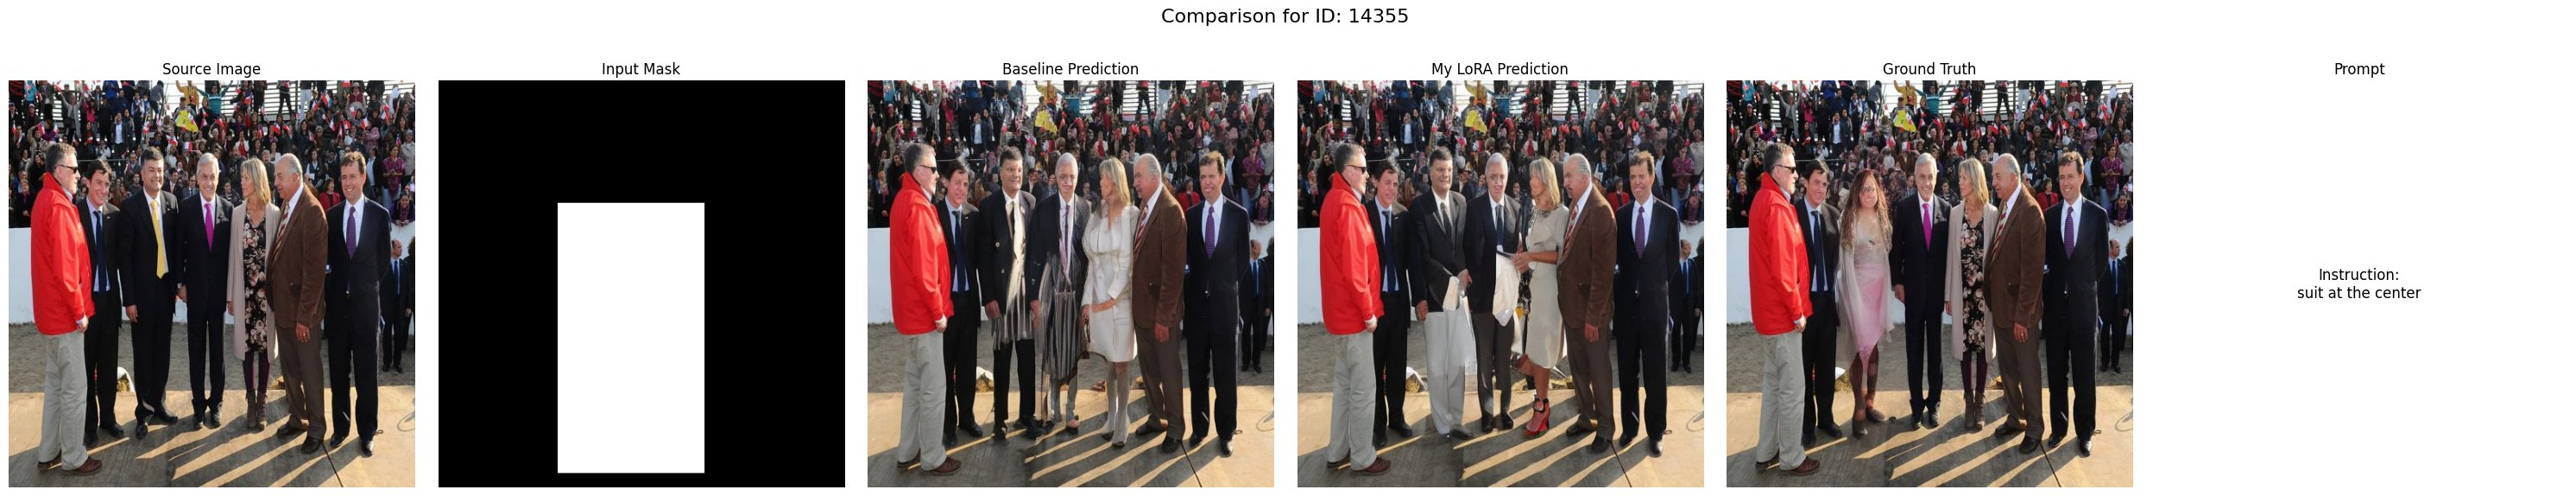

100%|██████████| 50/50 [00:02<00:00, 22.49it/s]


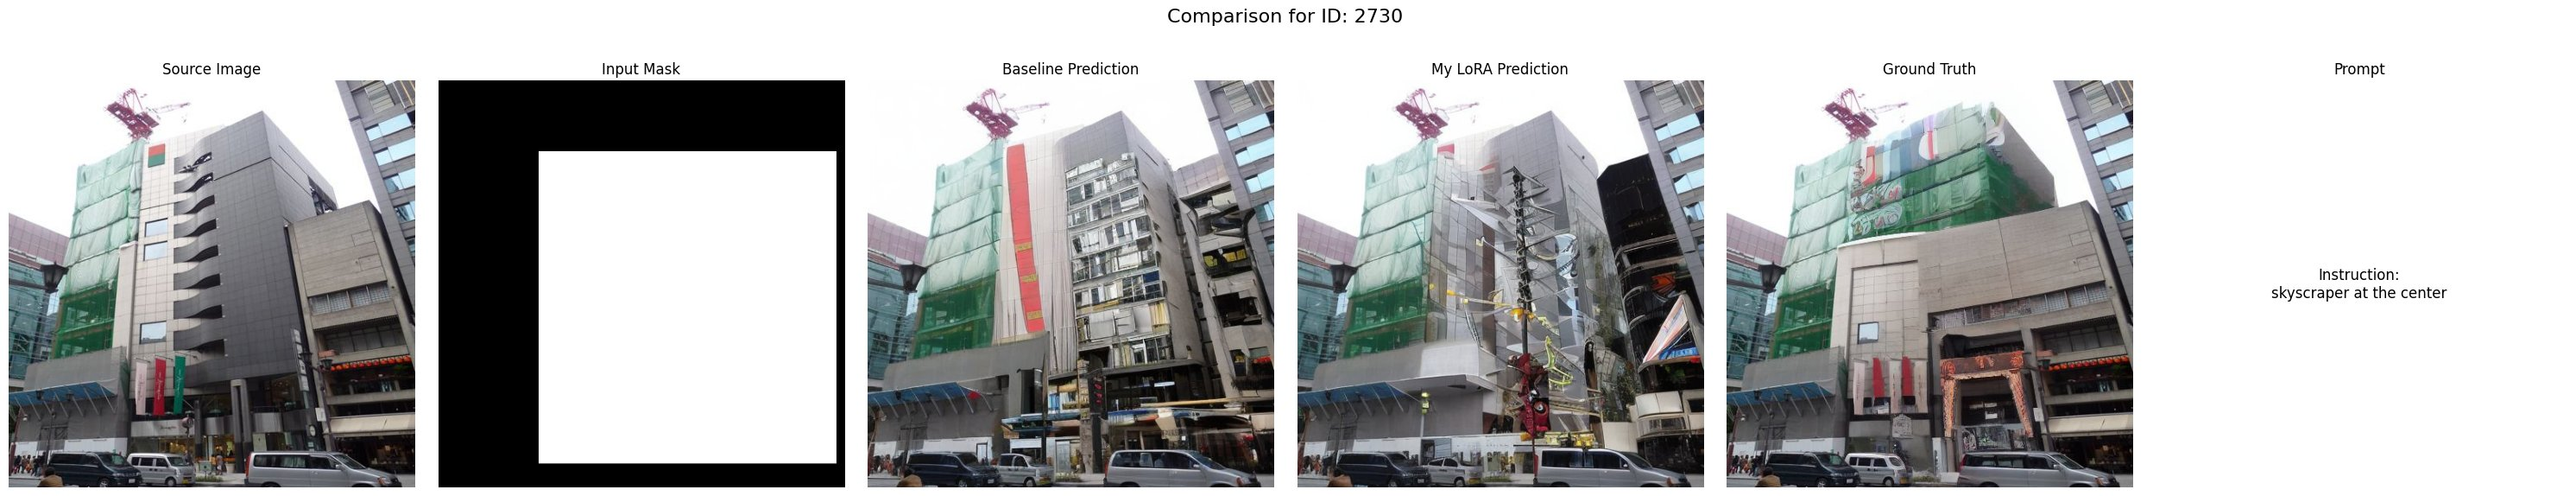

100%|██████████| 50/50 [00:02<00:00, 22.48it/s]


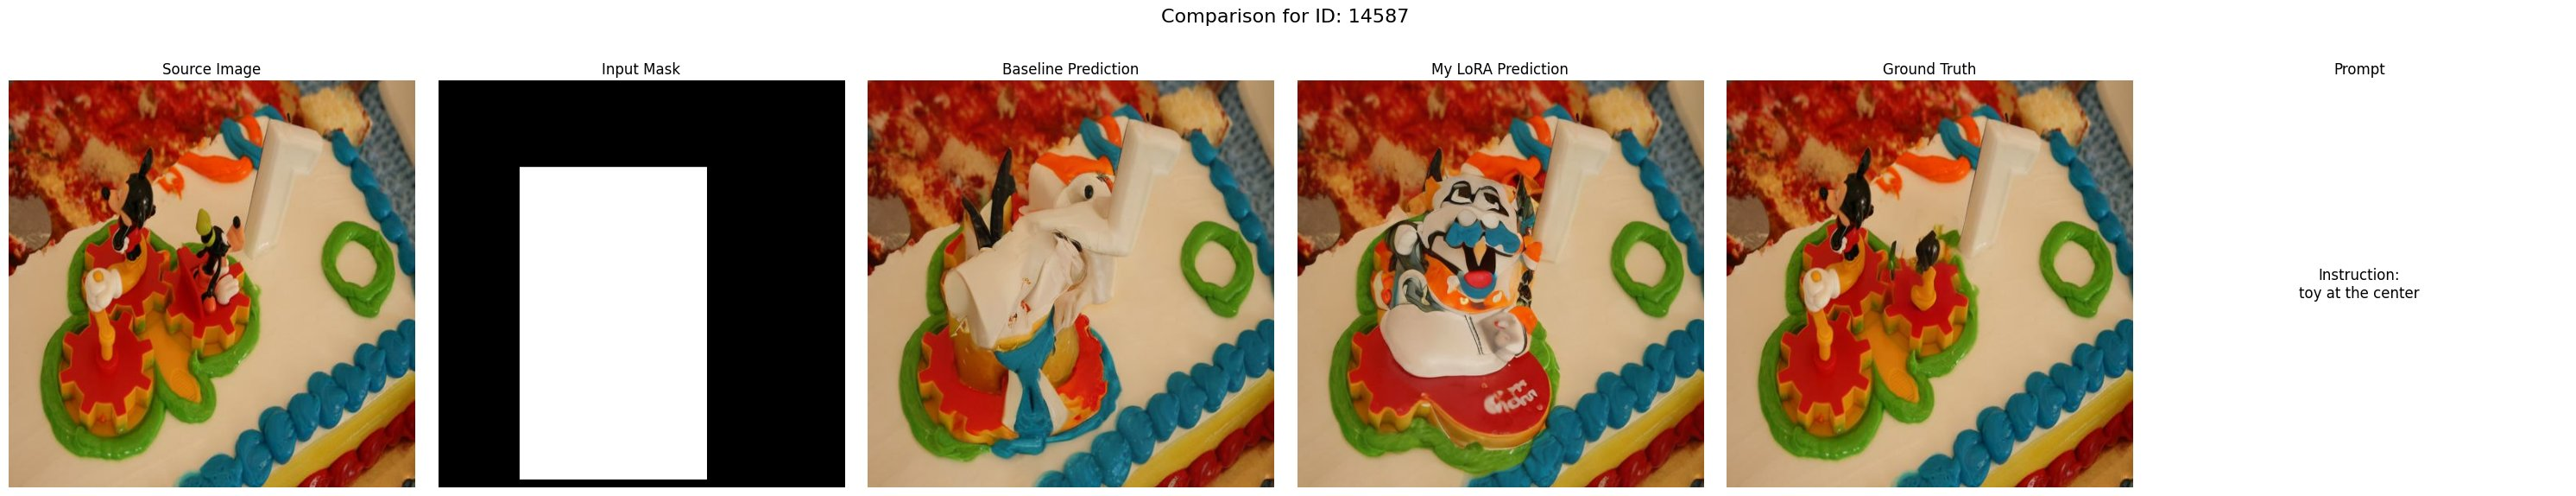

100%|██████████| 50/50 [00:02<00:00, 22.44it/s]


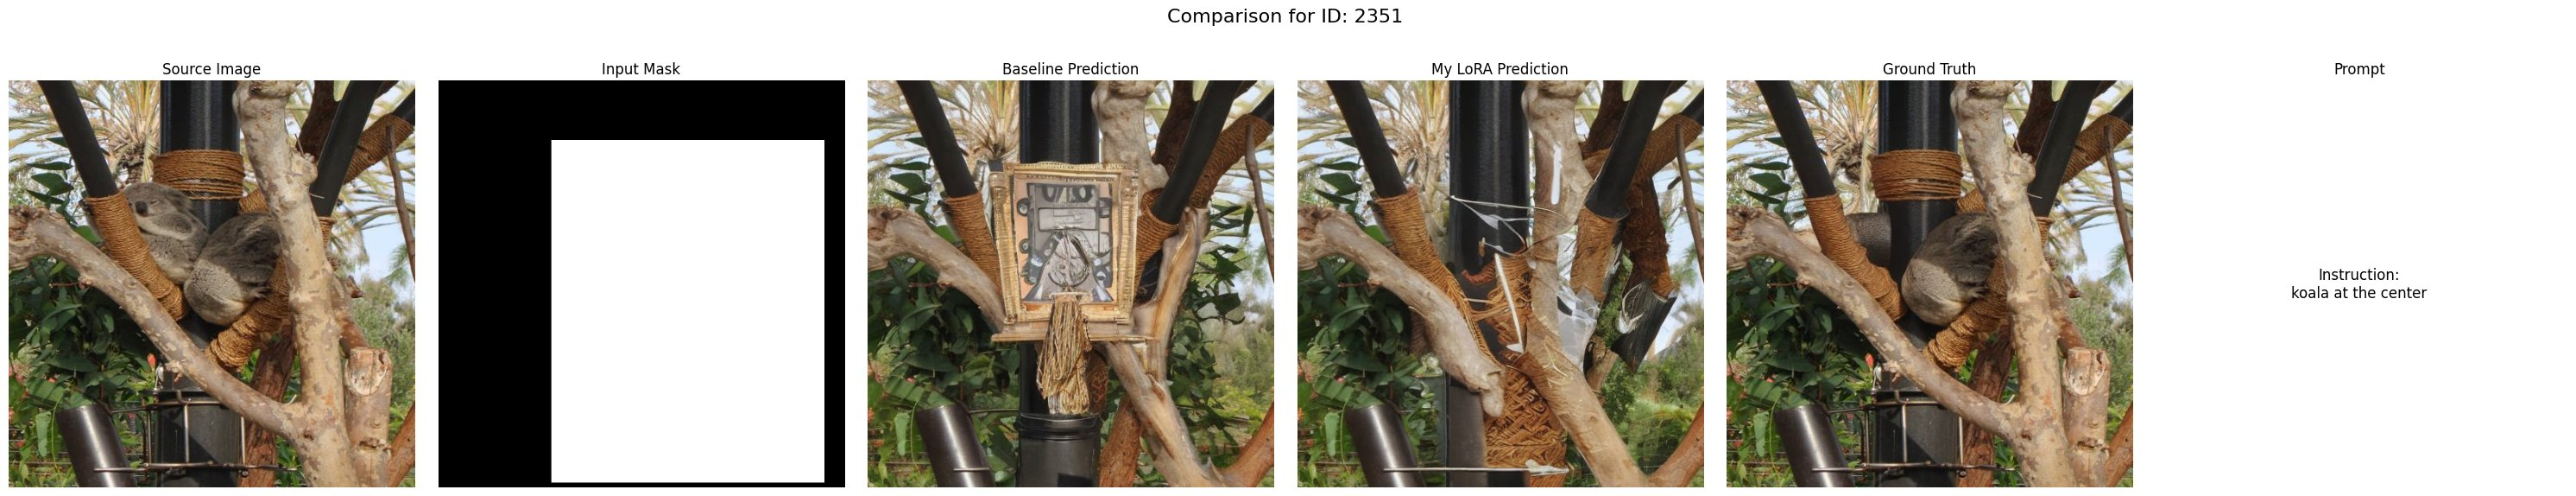

100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


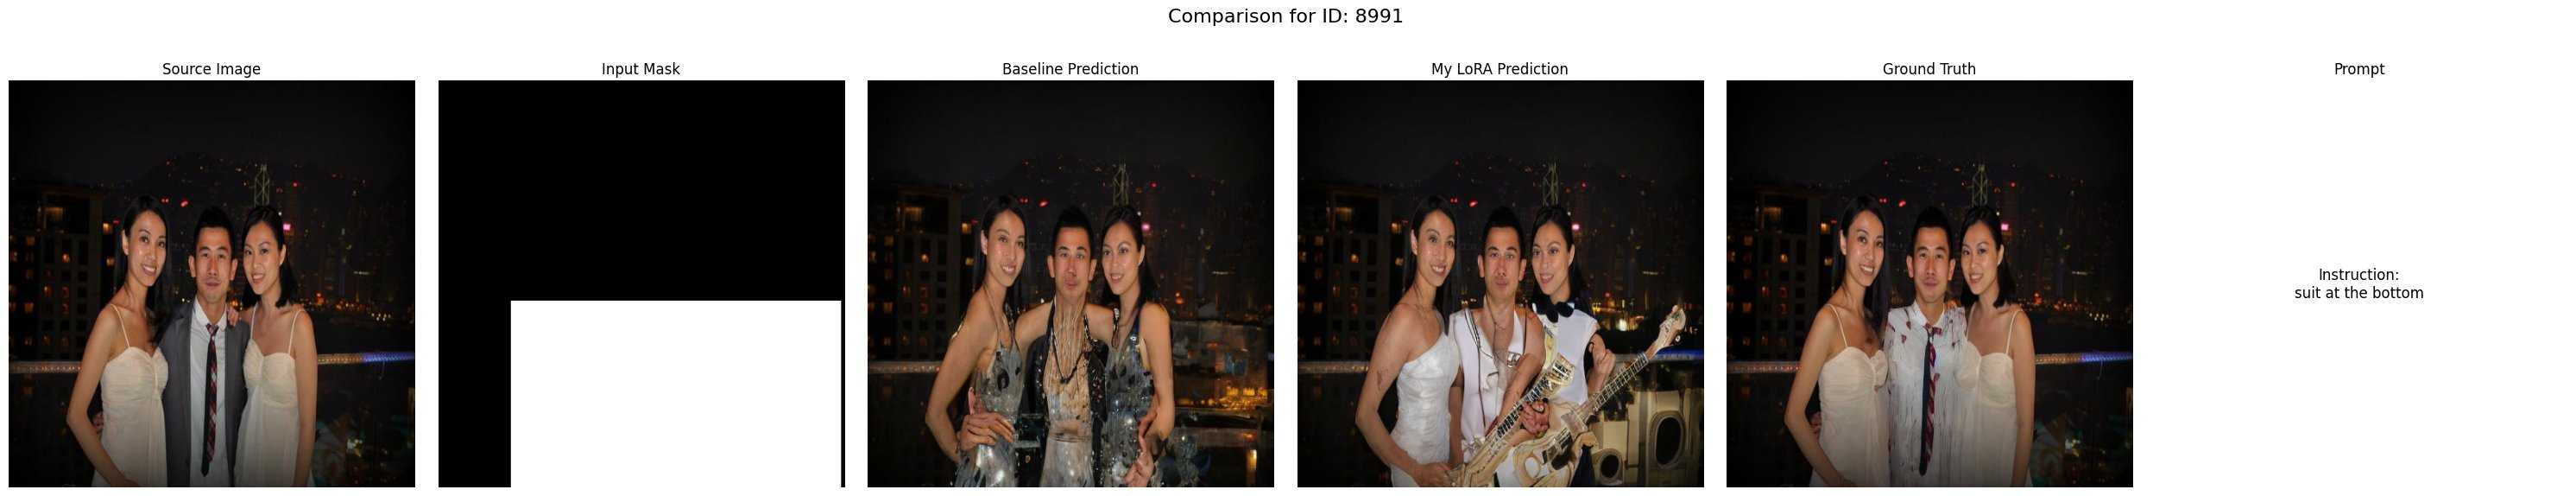

100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


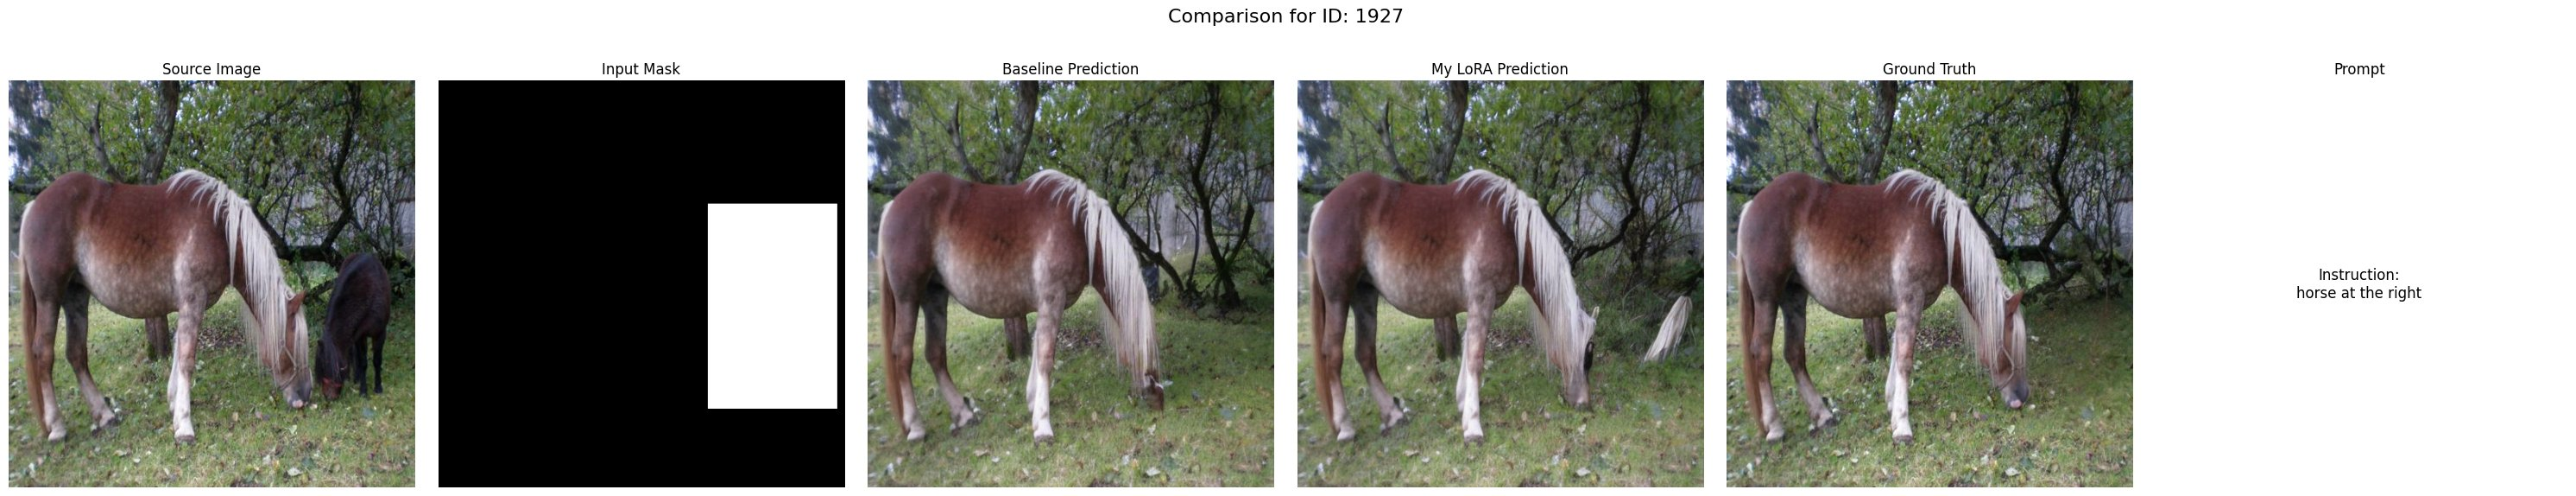

100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


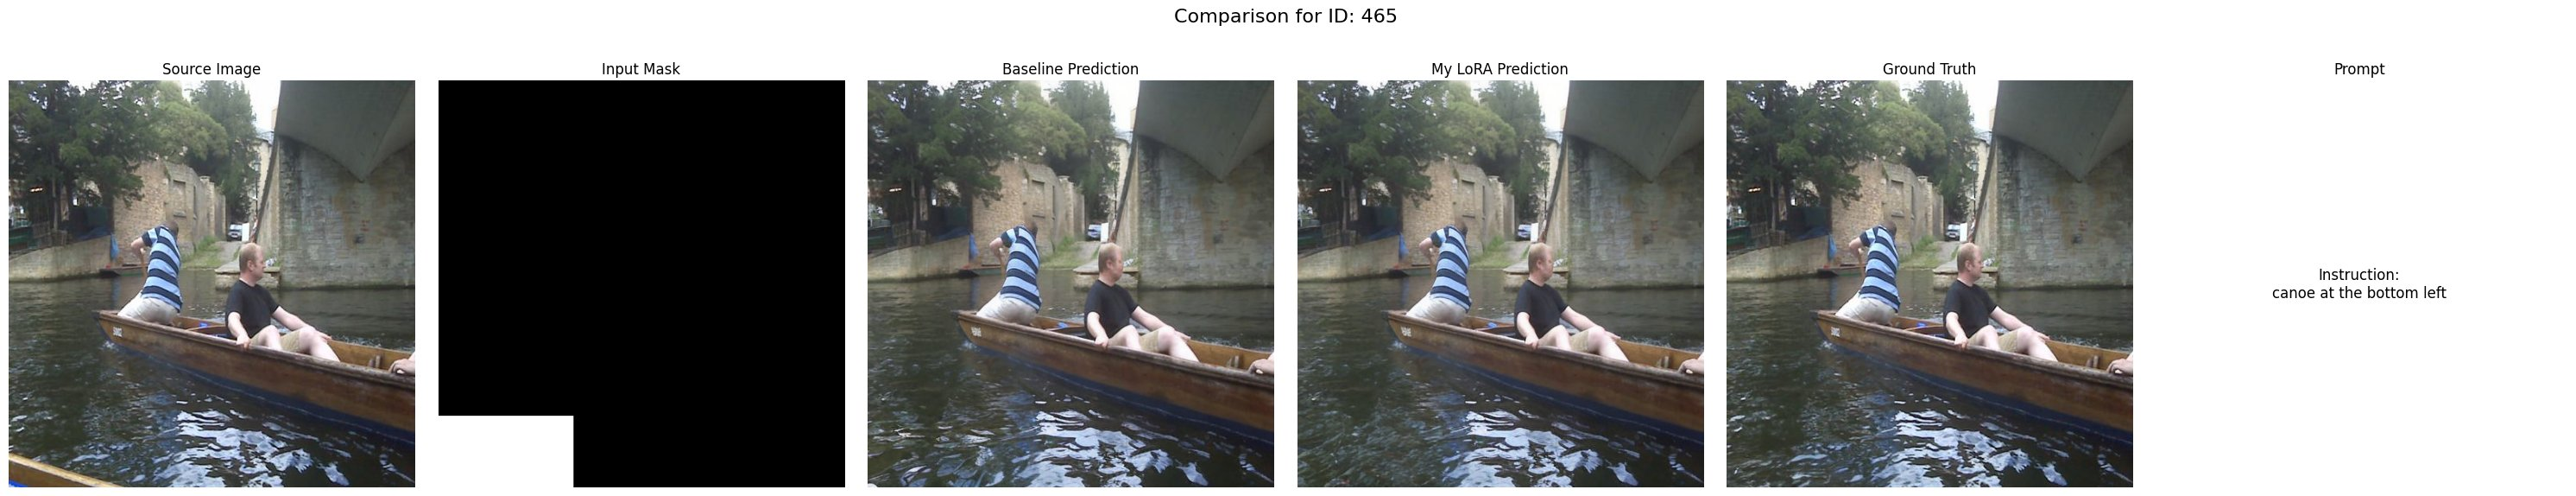

100%|██████████| 50/50 [00:02<00:00, 21.60it/s]


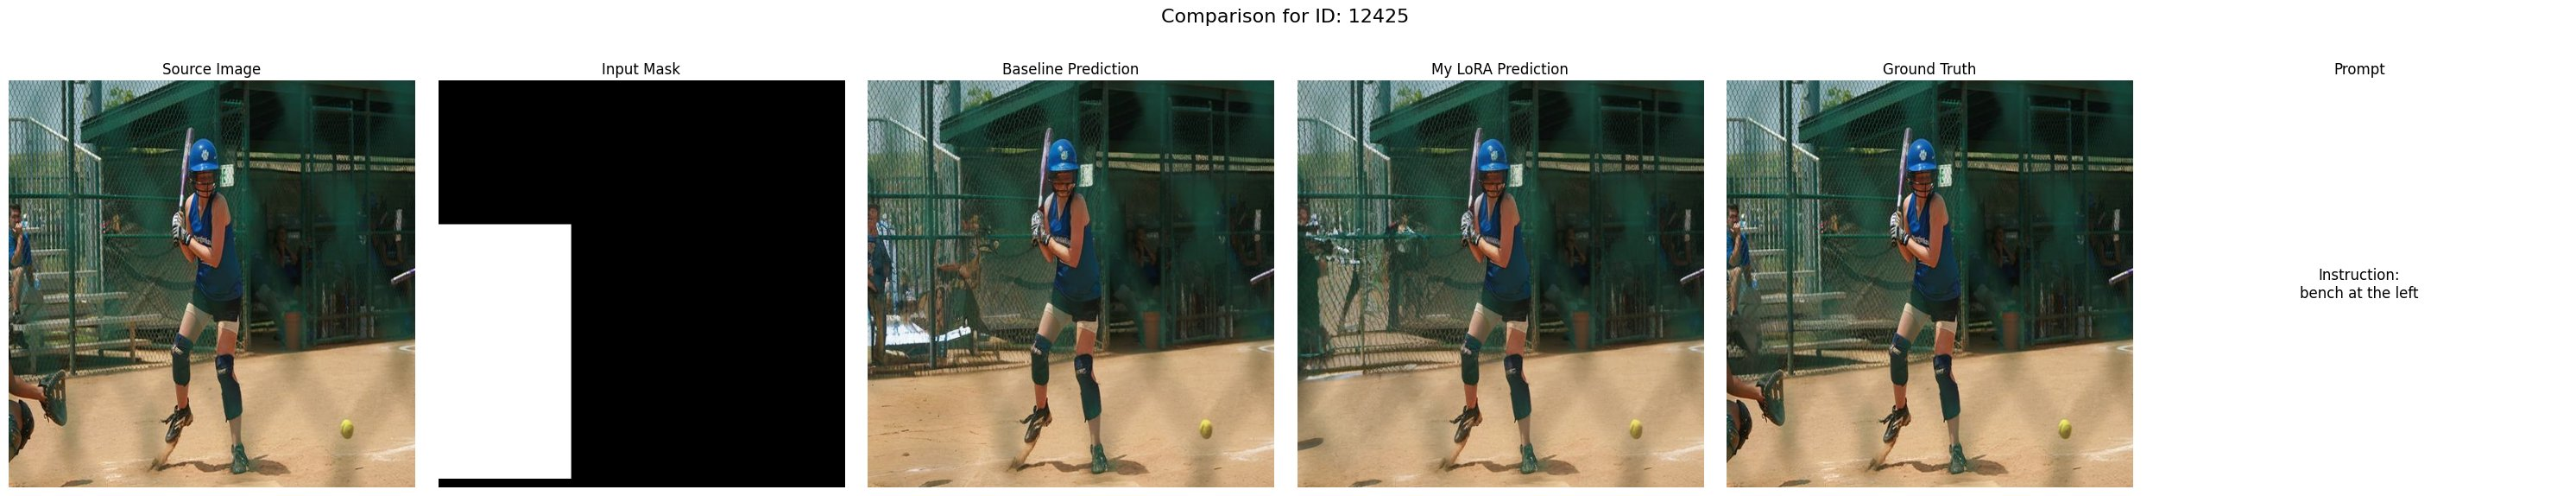

100%|██████████| 50/50 [00:02<00:00, 21.62it/s]


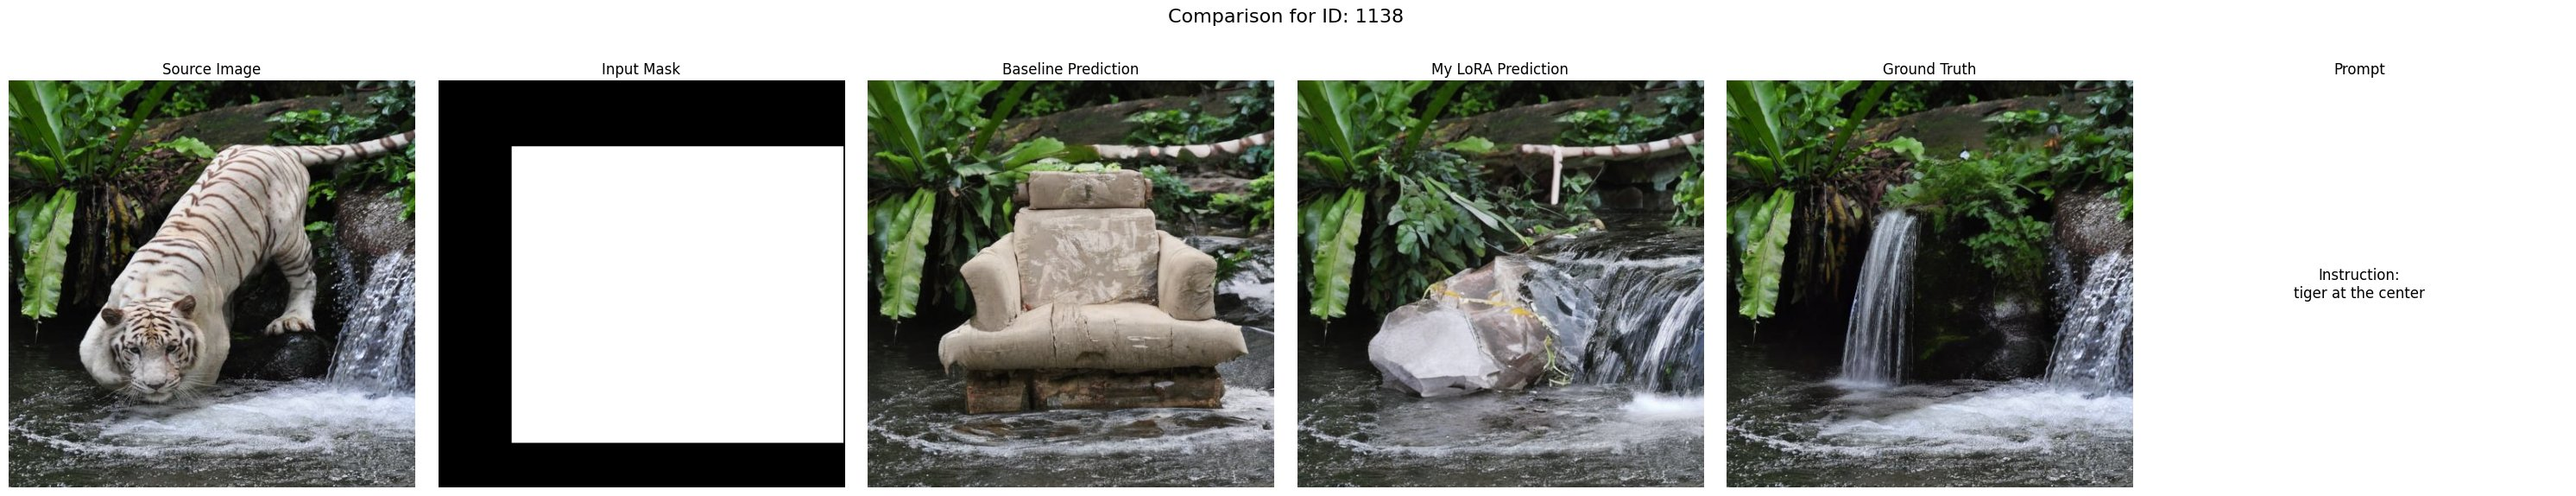

100%|██████████| 50/50 [00:02<00:00, 21.61it/s]


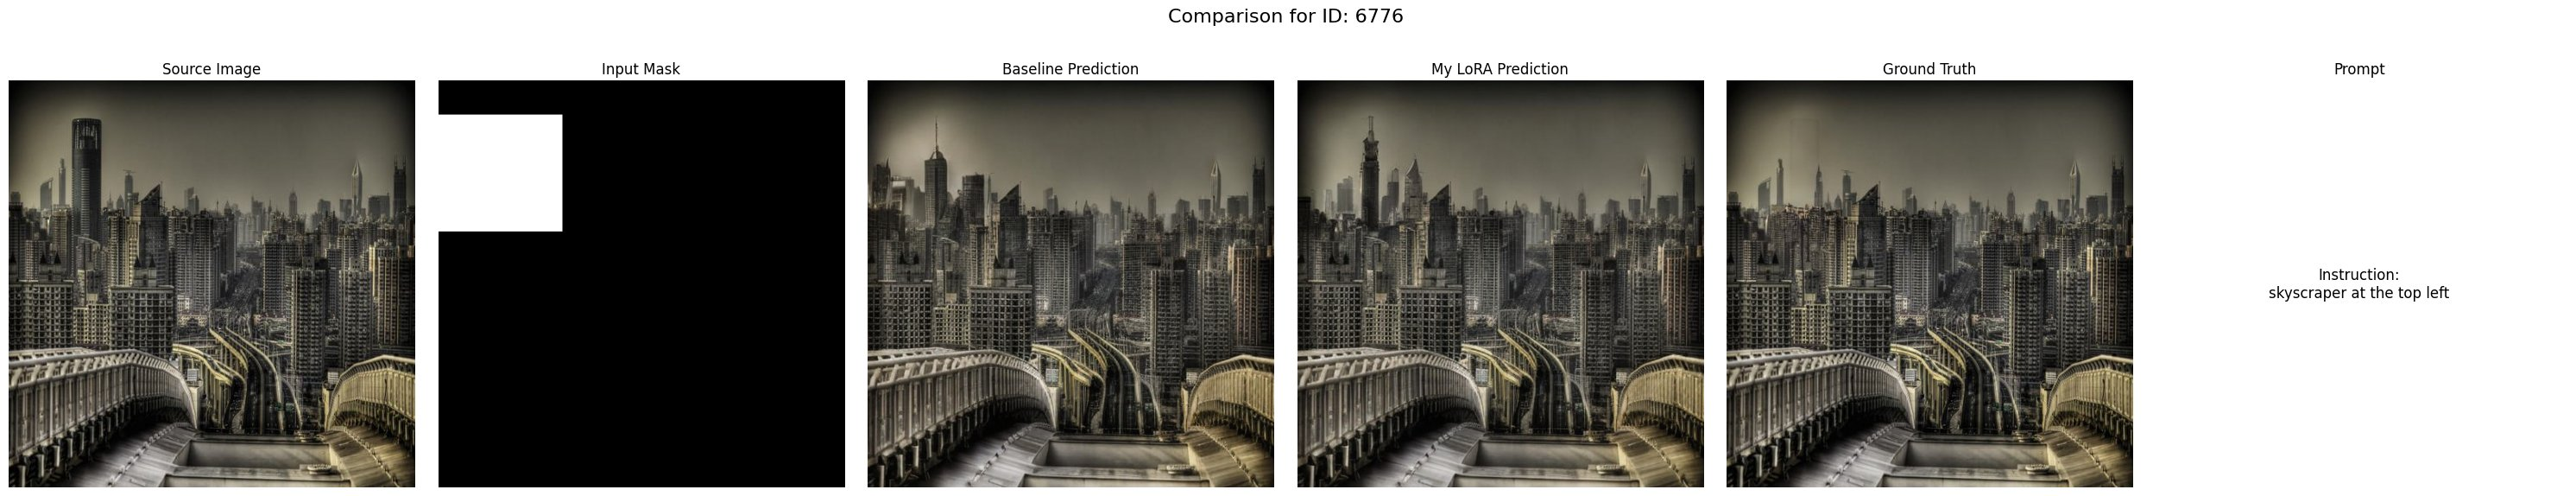

Generating comparison plots: 100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [ ]:
random.seed(237)  # For reproducibility
num_samples_to_show = 10
if len(test_image_pairs) < num_samples_to_show:
    print(f"Warning: Only found {len(test_image_pairs)} samples. Showing all of them.")
    num_samples_to_show = len(test_image_pairs)

selected_samples = random.sample(test_image_pairs, num_samples_to_show)

print(f"\n Displaying {num_samples_to_show} random comparisons from the TEST set ")

for sample_entry in tqdm(selected_samples, desc="Generating comparison plots"):
    
    image_filename = os.path.basename(sample_entry["image"])
    image_id = extract_id(image_filename)
    
    # Load images and mask
    source_img = Image.open(sample_entry["image"]).convert("RGB").resize((512, 512))
    mask_img = Image.open(sample_entry["mask"]).convert("L").resize((512, 512))
    target_img = Image.open(sample_entry["target"]).convert("RGB").resize((512, 512))
    
    prompt = ""
    generator = torch.Generator(device="cuda").manual_seed(42)

    with torch.no_grad():
        # Baseline model prediction
        baseline_img = baseline_pipe(prompt=prompt, image=source_img, mask_image=mask_img, generator=generator).images[0]
        # Fine-tuned model's prediction
        predicted_img = fine_tuned_pipe(prompt=prompt, image=source_img, mask_image=mask_img, generator=generator).images[0]

    #  Visualize the results 
    fig, axs = plt.subplots(1, 6, figsize=(30, 6))
    fig.suptitle(f'Comparison for ID: {image_id}', fontsize=16)

    axs[0].imshow(source_img); axs[0].set_title("Source Image"); axs[0].axis('off')
    axs[1].imshow(mask_img, cmap='gray'); axs[1].set_title("Input Mask"); axs[1].axis('off')
    axs[2].imshow(baseline_img); axs[2].set_title("Baseline Prediction"); axs[2].axis('off')
    axs[3].imshow(predicted_img); axs[3].set_title("My LoRA Prediction"); axs[3].axis('off')
    axs[4].imshow(target_img); axs[4].set_title("Ground Truth"); axs[4].axis('off')
    
    with open(sample_entry["instruction"], 'r') as f:
        instruction_text = f.read().strip()
    axs[5].text(0.5, 0.5, f"Instruction:\n{instruction_text}", fontsize=12, ha='center', va='center', wrap=True)
    axs[5].set_title("Prompt"); axs[5].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


---


*The following qualitative analysis is based on a random selection of test set images. By visually comparing the outputs of our fine-tuned LoRA model against the original Stable Diffusion baseline, we can gain a deeper understanding of the strengths and weaknesses of our approach and make a final judgment on the success of our fine-tuning.*



#### **Clear Successes of LoRA Fine-Tuning**
In the majority of cases, the fine-tuned LoRA model demonstrates an improvement over the baseline, particularly in its ability to understand the context of the scene.

* **Contextual Awareness:** In examples like the **tiger (ID: 1138)** and the **canoe (ID: 465)**, the baseline model fails conceptually. It replaces the tiger with a stone statue and struggles with the water texture. Our LoRA model, in contrast, correctly understands that it needs to inpaint a natural background and flawlessly reconstructs the waterfall, rocks, and water reflections, producing a result very close to the ground truth.

* **Seamless Integration:** When removing the **bench (ID: 12425)** and the **suit in the crowd (ID: 14355)**, our model creates a more seamless and plausible fill. It does a better job of continuing the textures and patterns of the surrounding environment, whereas the baseline's output can sometimes look blurry or generic.


#### **Shared Challenges and the "Human Problem"**
While our model is a clear improvement, the comparison also highlights some difficult cases where both models struggle. These represent the current limitations of this inpainting approach.

* **Conceptual Misunderstanding:** In some cases, like the **toy on the cake (ID: 14587)** or the **koala (ID: 2351)**, both models seem to interpret the task as "replace the object" rather than "remove the object." They inpaint a different, often distorted, version of the object instead of the background (the cake frosting or the tree trunk). This suggests a fundamental challenge that was not fully solved by fine-tuning.

* **The Difficulty of Inpainting People:** The most significant challenge is inpainting human figures and faces. In the **suit at the bottom (ID: 8991)** example, both models fail spectacularly. When asked to reconstruct a complex area involving clothing and human anatomy, they produce distorted, nonsensical imagery (our model hallucinates a saxophone-like object). This is a well-known problem in generative AI; our brains are highly sensitive to errors in human forms, making this an extremely difficult task for any model.

#### **Overall Verdict**
Despite the challenges with complex human anatomy, the results are positive. The LoRA fine-tuning has proven to be **highly effective**, transforming a general-purpose inpainting model into a specialized tool that shows a much deeper understanding of contextual object removal. For the vast majority of cases, especially involving objects in natural or structural scenes, our model is a definitive and dramatic improvement over the baseline.